<a href="https://colab.research.google.com/github/moreymat/scpo-data-science-bootcamp/blob/main/notebooks/3_dataviz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data visualization

In this notebook, we will see how to build some data visualizations for our OpenFoodFacts dataset.

## Loading the data

In [1]:
# (just execute this cell)

# enable Colab to access files (here shortcuts) on your Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# (just execute this cell)

# import pandas
import csv
import pandas as pd

# we need this data type for ordered categoricals
from pandas.api.types import CategoricalDtype

# lift some limitations in column width, so more cell values are displayed in full
pd.set_option("display.max_colwidth", 110)

# dataset and data type of the columns
FOLDER = "../data/processed"  # "drive/MyDrive"
OFF_FILE = f"{FOLDER}/off_products_subset.csv"
DTYPE_FILE = f"{FOLDER}/dtype.txt"


# custom function to load the Open Food Facts subset
def load_off():
    """Load the filtered subset of Open Food Facts.

    Returns
    -------
    df : pd.DataFrame
      (A filtered subset of the) Open Food Facts tabular dataset.
    """
    # load the data types for the columns
    with open(DTYPE_FILE) as f:
        dtype = eval(f.read())

    # load the dataset
    df = pd.read_csv(OFF_FILE, sep="\t", dtype=dtype, quoting=csv.QUOTE_NONE)
    # convert columns with datetimes
    for col_name in (
        "created_datetime",
        "last_modified_datetime",
        "last_updated_datetime",
        "last_image_datetime",
    ):
        # ISO 8601 dates
        df[col_name] = pd.to_datetime(df[col_name])
    #
    return df


# load the dataset (takes around 60 seconds)
df = load_off()

Let us clean up the dataset by applying the same procedure as in the previous notebook: Drop products that contain clear outliers for the nutritional values `fat_100g`, `saturated-fat_100g`, `sugars_100g`, `salt_100g`.

In [3]:
# (just execute this cell)
df = df.drop(
    index=df[
        (df["fat_100g"] > 100)
        | (df["saturated-fat_100g"] > 100)
        | (df["sugars_100g"] > 100)
        | (df["salt_100g"] > 100)
    ].index
)

We verify that summary statistics for these 4 nutritional values look reasonable.

In [4]:
# (just execute this cell)
df[["fat_100g", "saturated-fat_100g", "sugars_100g", "salt_100g"]].mean()

fat_100g              13.851002
saturated-fat_100g     5.113861
sugars_100g           12.486285
salt_100g              1.167740
dtype: float64

Ideally, we should perform similar checks on other columns and look for more dubious entries to filter out.
But, for the scope of this course, we assume the dataset is now reasonably clean.

We can focus on building data visualizations that support [Exploratory Data Analysis (EDA)](https://en.wikipedia.org/wiki/Exploratory_data_analysis), or that can be used to get insights and communicate with stakeholders.

## Simple visualizations on OpenFoodFacts

### Seaborn

[Seaborn](https://seaborn.pydata.org/) is a data visualization library for Python.
It provides a simpler, higher-level interface to the powerful but cumbersome library [matplotlib](https://matplotlib.org/), and enables to quickly build readable dataviz.

We need to import the seaborn library, whose conventional alias is `sns`.

In [5]:
import seaborn as sns

## Nutri-Score

Nutri-Score grades are an ordered categorical variable, with 5 values ranging from A (healthy) to E (unhealthy).

These grades are based on an integer score, ranging from -15 (A) to +40 (E).
This score is computed as a sum of positive and negative points attributed based on nutritional values and ingredients, with separate scales for big categories of products.

In this section, we will build graphs to visualize Nutri-Score grades and scores.

To facilitate their reading, we will use the color palette of the Nutri-Score grades.

In [6]:
# color palette of the Nutri-Score grades
colors_nutriscore = {
    "a": "#058244",
    "b": "#85BD39",
    "c": "#FDCD2A",
    "d": "#ED831E",
    "e": "#E53F1A",
}

### Visualizing categorical data : Nutri-Score grade

Seaborn enables to visualize categorical variables in a [variety of manners](https://seaborn.pydata.org/tutorial/categorical.html#plotting-with-categorical-data).

These visualizations can be built by calling the high-level function `catplot` and specifying, among other arguments, the type of categorical plot we want.

Let us try to answer the following vague question : "How healthy are the products sold in supermarkets ?".

This can translate to this more precise question : "How many products of each Nutri-Score grade does the dataset contain?".

We can answer the latter question by building a plot that represents, for each Nutri-Score grade, the total number of products in the dataset.
This corresponds in seaborn, and in the documentation page linked above, to a **count plot**.

Because a count plot is a special kind of categorical plot, we will call the high-level function [catplot](https://seaborn.pydata.org/generated/seaborn.catplot.html) with the arguments describing that we want to build,
* a count plot: `kind='count'`,
* on our dataset: `data=df`,
* with one count bar for each Nutri-Score grade: `x=nutriscore_grade`,
* where each bar is colored after the Nutri-Score grade: `hue=nutriscore_grade`,
* following the Nutri-Score color palette : `palette=colors_nutriscore`.

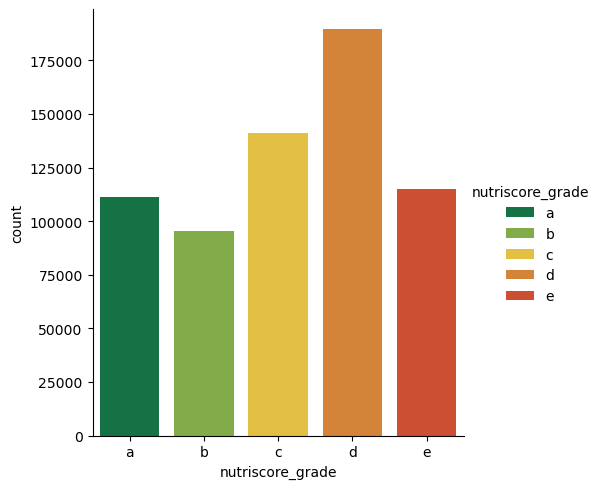

In [7]:
# (just execute this cell)
sns.catplot(
    data=df,
    x="nutriscore_grade",
    hue="nutriscore_grade",
    kind="count",
    palette=colors_nutriscore,
)

This is the overall distribution of Nutri-Score grades on products across brands, but maybe some brands produce healthier products than others.

To quickly explore this hypothesis, let us look at the 9 most frequent brands in the dataset :

* count brands using the [value_counts](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) method, with the result sorted in descending order,
* slice this result to keep the first 9,
* store the result in a variable named `top_brands`.

In [8]:
# select the 9 most frequent brands
top_brands = df["brands"].value_counts()[:9]
top_brands

brands
Carrefour       12909
Auchan           9950
U                6024
Hacendado        4333
Delhaize         3996
Casino           3805
Coop             3790
Leader Price     3369
Lidl             3092
Name: count, dtype: Int64

The top 9 brands should be:
* Carrefour,
* Auchan,
* U,
* Hacendado,
* Delhaize,
* Casino,
* Coop,
* Leader Price,
* Lidl

To retrieve the names of these 9 brands, rather than their counts, we need to use the [keys](https://pandas.pydata.org/docs/reference/api/pandas.Series.keys.html) method. Store the result in a variable named `top_brands_names`.

In [9]:
top_brands_names = top_brands.keys()
top_brands_names

Index(['Carrefour', 'Auchan', 'U', 'Hacendado', 'Delhaize', 'Casino', 'Coop',
       'Leader Price', 'Lidl'],
      dtype='string', name='brands')

Filter the products from these top 9 brands using [isin](https://pandas.pydata.org/docs/reference/api/pandas.Series.isin.html) and store this subset in a new variable `df_top_brands`.

In [10]:
df_top_brands = df[df["brands"].isin(top_brands_names)]
df_top_brands

,code,url,creator,created_datetime,last_modified_datetime,last_modified_by,last_updated_datetime,product_name,generic_name,quantity,...,vitamin-a_100g,vitamin-d_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,potassium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
6,0000209773750,http://world-en.openfoodfacts.org/product/0000209773750/tortitas-de-trigo-roti-wraps-lidl,kiliweb,2021-06-12 08:56:14+00:00,2023-12-04 19:29:11+00:00,mariacastiel,2024-02-13 15:27:29+00:00,Tortitas de trigo- Roti wraps,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
123,0003312709371,http://world-en.openfoodfacts.org/product/0003312709371/peren-williams-lichte-siroop-carrefour,foodvisor,2024-02-11 09:31:23+00:00,2024-02-13 10:48:44+00:00,annelotte,2024-02-14 06:29:45+00:00,Peren Williams lichte siroop,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
145,0004949122113,http://world-en.openfoodfacts.org/product/0004949122113/garlic-baguette-coop,honey4d,2024-03-20 18:48:26+00:00,2024-03-20 18:56:29+00:00,honey4d,2024-03-20 18:56:29+00:00,Garlic Baguette,<NA>,205g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.604167,<NA>
281,0008880063412,http://world-en.openfoodfacts.org/product/0008880063412/muesli-bio-au-chocolat-lidl,foodvisor,2022-04-28 08:59:27+00:00,2023-01-31 18:38:03+00:00,wolfgang8741,2024-02-13 21:32:31+00:00,Muesli bio au chocolat,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
3102,0012641007263,http://world-en.openfoodfacts.org/product/0012641007263/ketchup-zero-hacendado,foodvisor,2024-05-21 12:37:49+00:00,2024-07-10 03:10:07+00:00,fabi2,2024-07-10 03:10:07+00:00,Ketchup Zero,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778627,99000738,http://world-en.openfoodfacts.org/product/99000738/eau-minerale-naturelle-saint-antonin-u,openfoodfacts-contributors,2021-10-09 20:02:48+00:00,2024-04-04 05:15:05+00:00,roboto-app,2024-04-04 05:15:05+00:00,EAU Minérale Naturelle Saint Antonin,<NA>,1L,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
778672,99306579,http://world-en.openfoodfacts.org/product/99306579/filet-de-poulet-delhaize,kiliweb,2019-08-09 16:09:13+00:00,2020-11-14 15:40:03+00:00,teolemon,2024-02-11 05:05:17+00:00,Filet de poulet,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
778680,99393366,http://world-en.openfoodfacts.org/product/99393366/runder-rumsteak-lidl,kiliweb,2022-02-26 14:20:38+00:00,2023-06-30 12:44:05+00:00,worldtest,2024-02-13 20:20:04+00:00,Runder Rumsteak,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
778689,9950275000704,http://world-en.openfoodfacts.org/product/9950275000704/0-70-di-sconto-di-due-bottiglie-da-33cl-di-tuborg-...,openfoodfacts-contributors,2023-05-30 10:13:36+00:00,2023-05-30 13:10:33+00:00,roboto-app,2024-02-14 03:26:07+00:00,"0,70€ Di sconto di due bottiglie da 33cl di Tuborg Strong",<NA>,"1,0 cartoline",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,<NA>


You should get 51268 entries.

Now, we want to plot the distribution of Nutri-Score grades separately for each of these top brands.

This will be very similar to the previous graph, except we will make use of catplot's ability to display [multiple facets](https://seaborn.pydata.org/tutorial/categorical.html#showing-multiple-relationships-with-facets).

Changes are :

* we only want to plot products from the top brands (`data=df_top_brands`),
* we want to build a distinct plot for each brand (`col=brands`),
* and display 3 plots in a row, so it fits our screen (`col_wrap=3`).

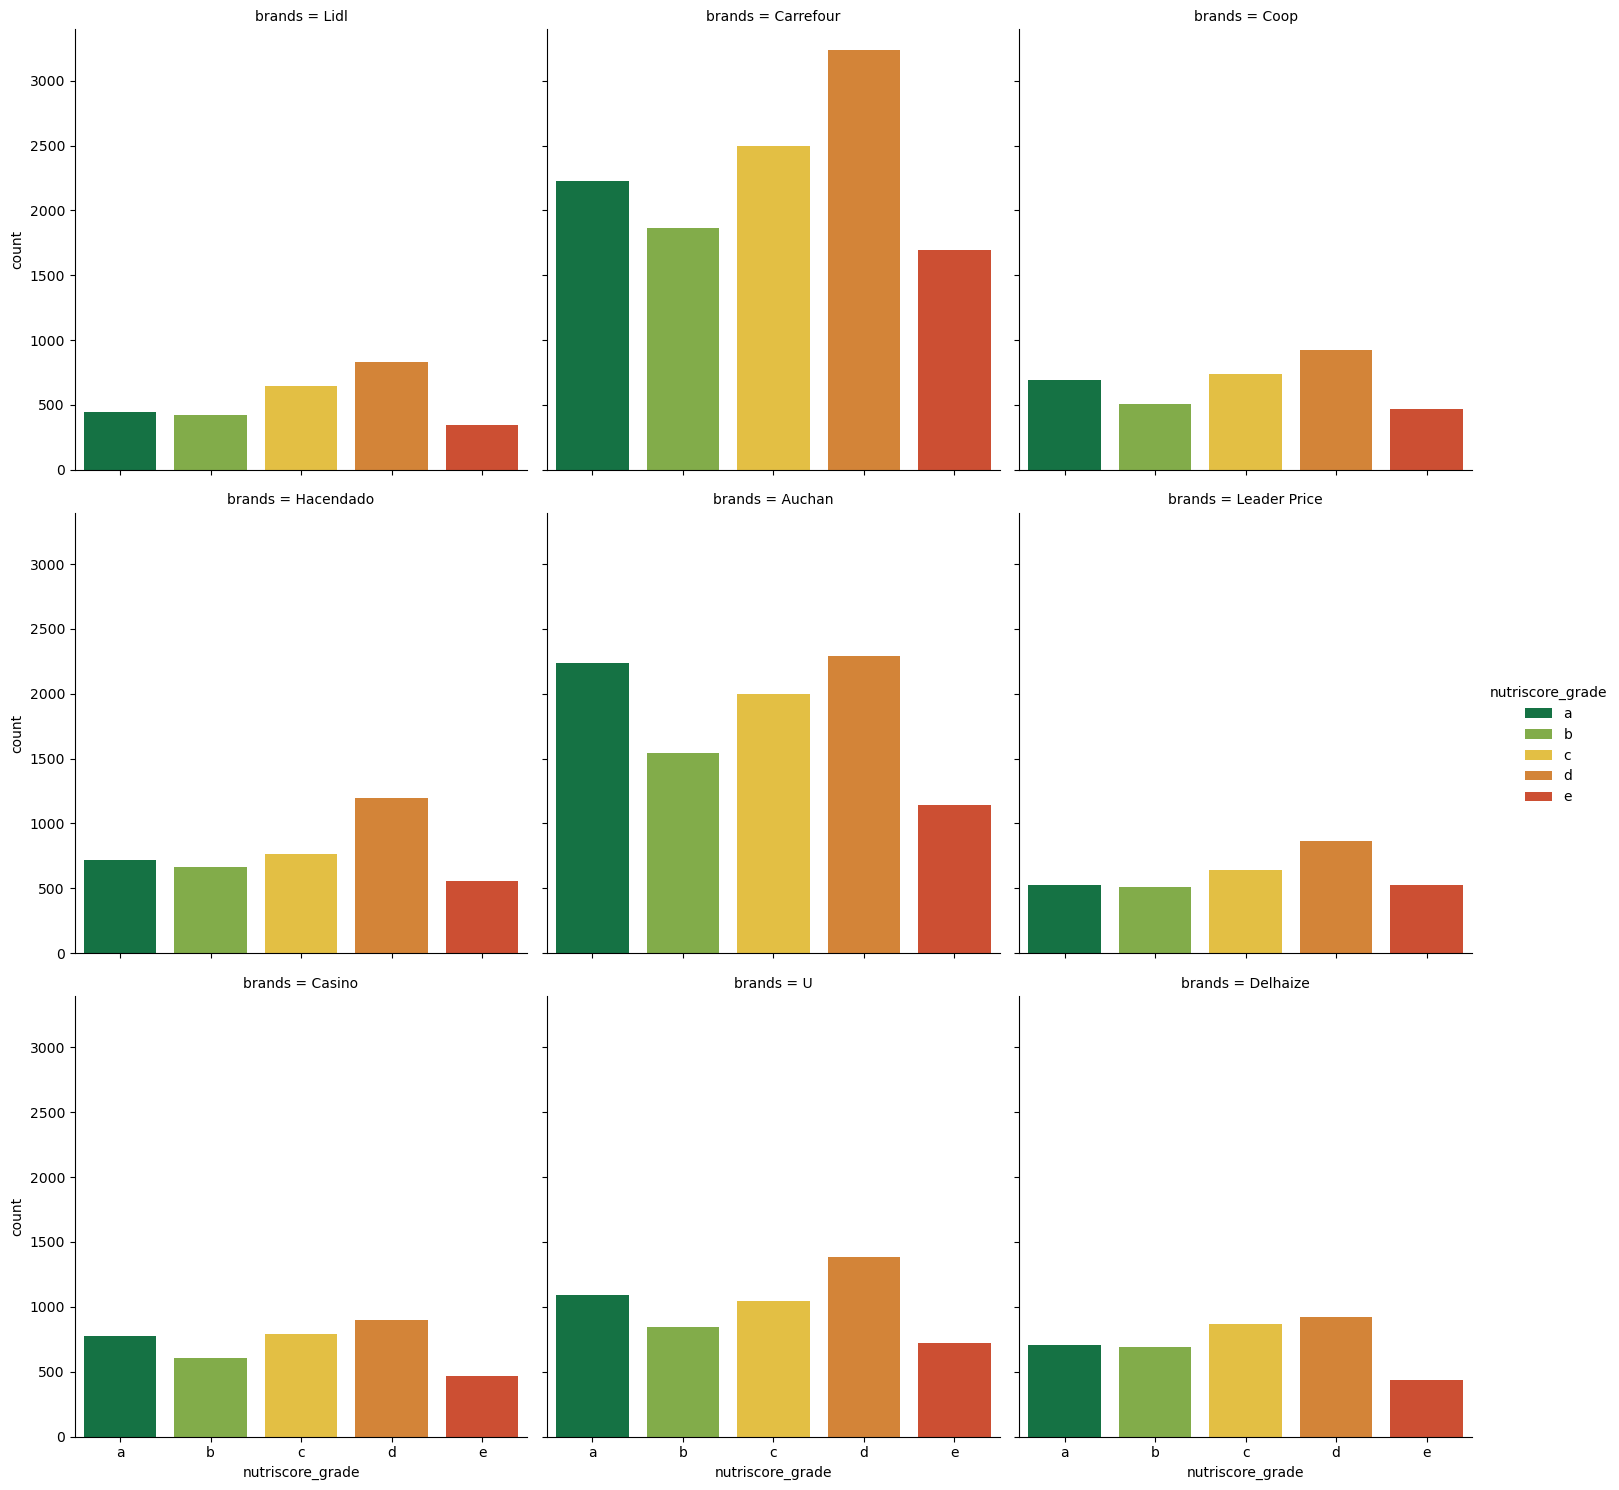

In [13]:
sns.catplot(
    data=df_top_brands,
    x="nutriscore_grade",
    hue="nutriscore_grade",
    kind="count",
    palette=colors_nutriscore,
    col="brands",
    col_wrap=3,
)

The distribution among Nutri-Score categories seems quite similar across brands:
* the mode is 'd',
* then 'c' followed by 'a', or the other way around,
* then 'b'
* then 'e'.

But Nutri-Score grades are a [binning](https://en.wikipedia.org/wiki/Grouped_data) of the underlying Nutri-Score scores.

Are the distributions of Nutri-Score scores equally similar across brands?

### Visualizing numerical data : Nutri-Score score

Nutri-Score scores range from -15 to 40, with [grades defined by thresholds (p. 32)](https://www.santepubliquefrance.fr/media/files/02-determinants-de-sante/nutrition-et-activite-physique/nutri-score/qr-scientifique-technique-en).
See also the schema summarizing the computation (p. 33).

For solid foods:
* A: <= 0
* B: 1 to 2
* C: 3 to 10
* D: 11 to 18
* E: >= 19

For animal and vegetable fats, nuts and seeds:
* A: <= -6
* B: -5 to 2
* C: 3 to 10
* D: 11 to 18
* E: >= 19

For beverages:
* A: waters
* B: <= 2
* C: 3 to 6
* D: 7 to 9
* E: >= 10

Visualizing the Nutri-Score scores, rather than the Nutri-Score grades, should provide a more accurate, finer-grained view of the healthiness of products according to the Nutri-Score methodology.

Because Nutri-Score scores correspond to a [quantitative variable](https://en.wikipedia.org/wiki/Quantification_(science)), we can plot the distribution of their values using [displot](https://seaborn.pydata.org/tutorial/distributions.html#plotting-univariate-histograms).

By default, `displot` builds a histogram (`kind='hist'`).
Because we know we only have integer values, we can additionally specify we want the bins of the histogram to correspond to [discrete values](https://en.wikipedia.org/wiki/Continuous_or_discrete_variable#Discrete_variable) (`discrete=True`). Otherwise, the bin sizes estimated by seaborn result in gaps that hinder readibility. 

First, let us build the distribution graph for the entire dataset.

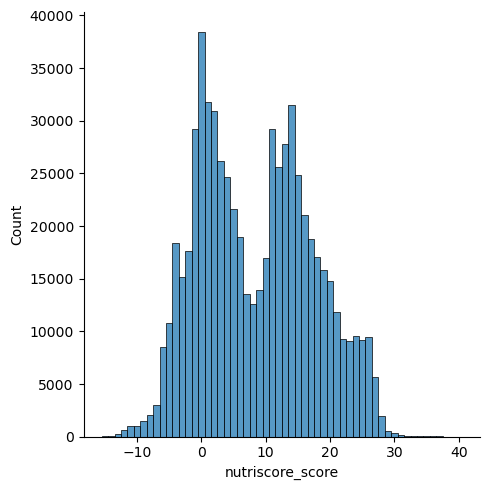

In [14]:
sns.displot(data=df, x="nutriscore_score", discrete=True)

This graph looks almost good, but too tight because it tries to fit many bars in a limited width.
We can modify the size of the figure of the displot by using parameters `height` (in inches) and `aspect`, where the figure width will be `height * aspect` (inches).
The default values are [`height=5` and `aspect=1`](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn.displot), so we will increase the `aspect` (eg. to `1.5`).

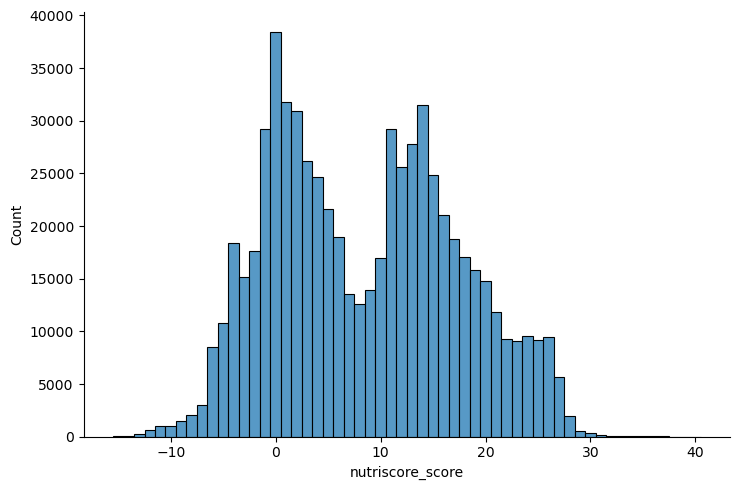

In [15]:
sns.displot(data=df, x="nutriscore_score", discrete=True, height=5, aspect=1.5)

The readability of the graph is increased, as expected.

Then let us produce the same type of distribution graph, but for each of the top brands we selected earlier.
Remember to change the data and add the extra arguments that tell seaborn what distinct plots it should build and what their layout should be.

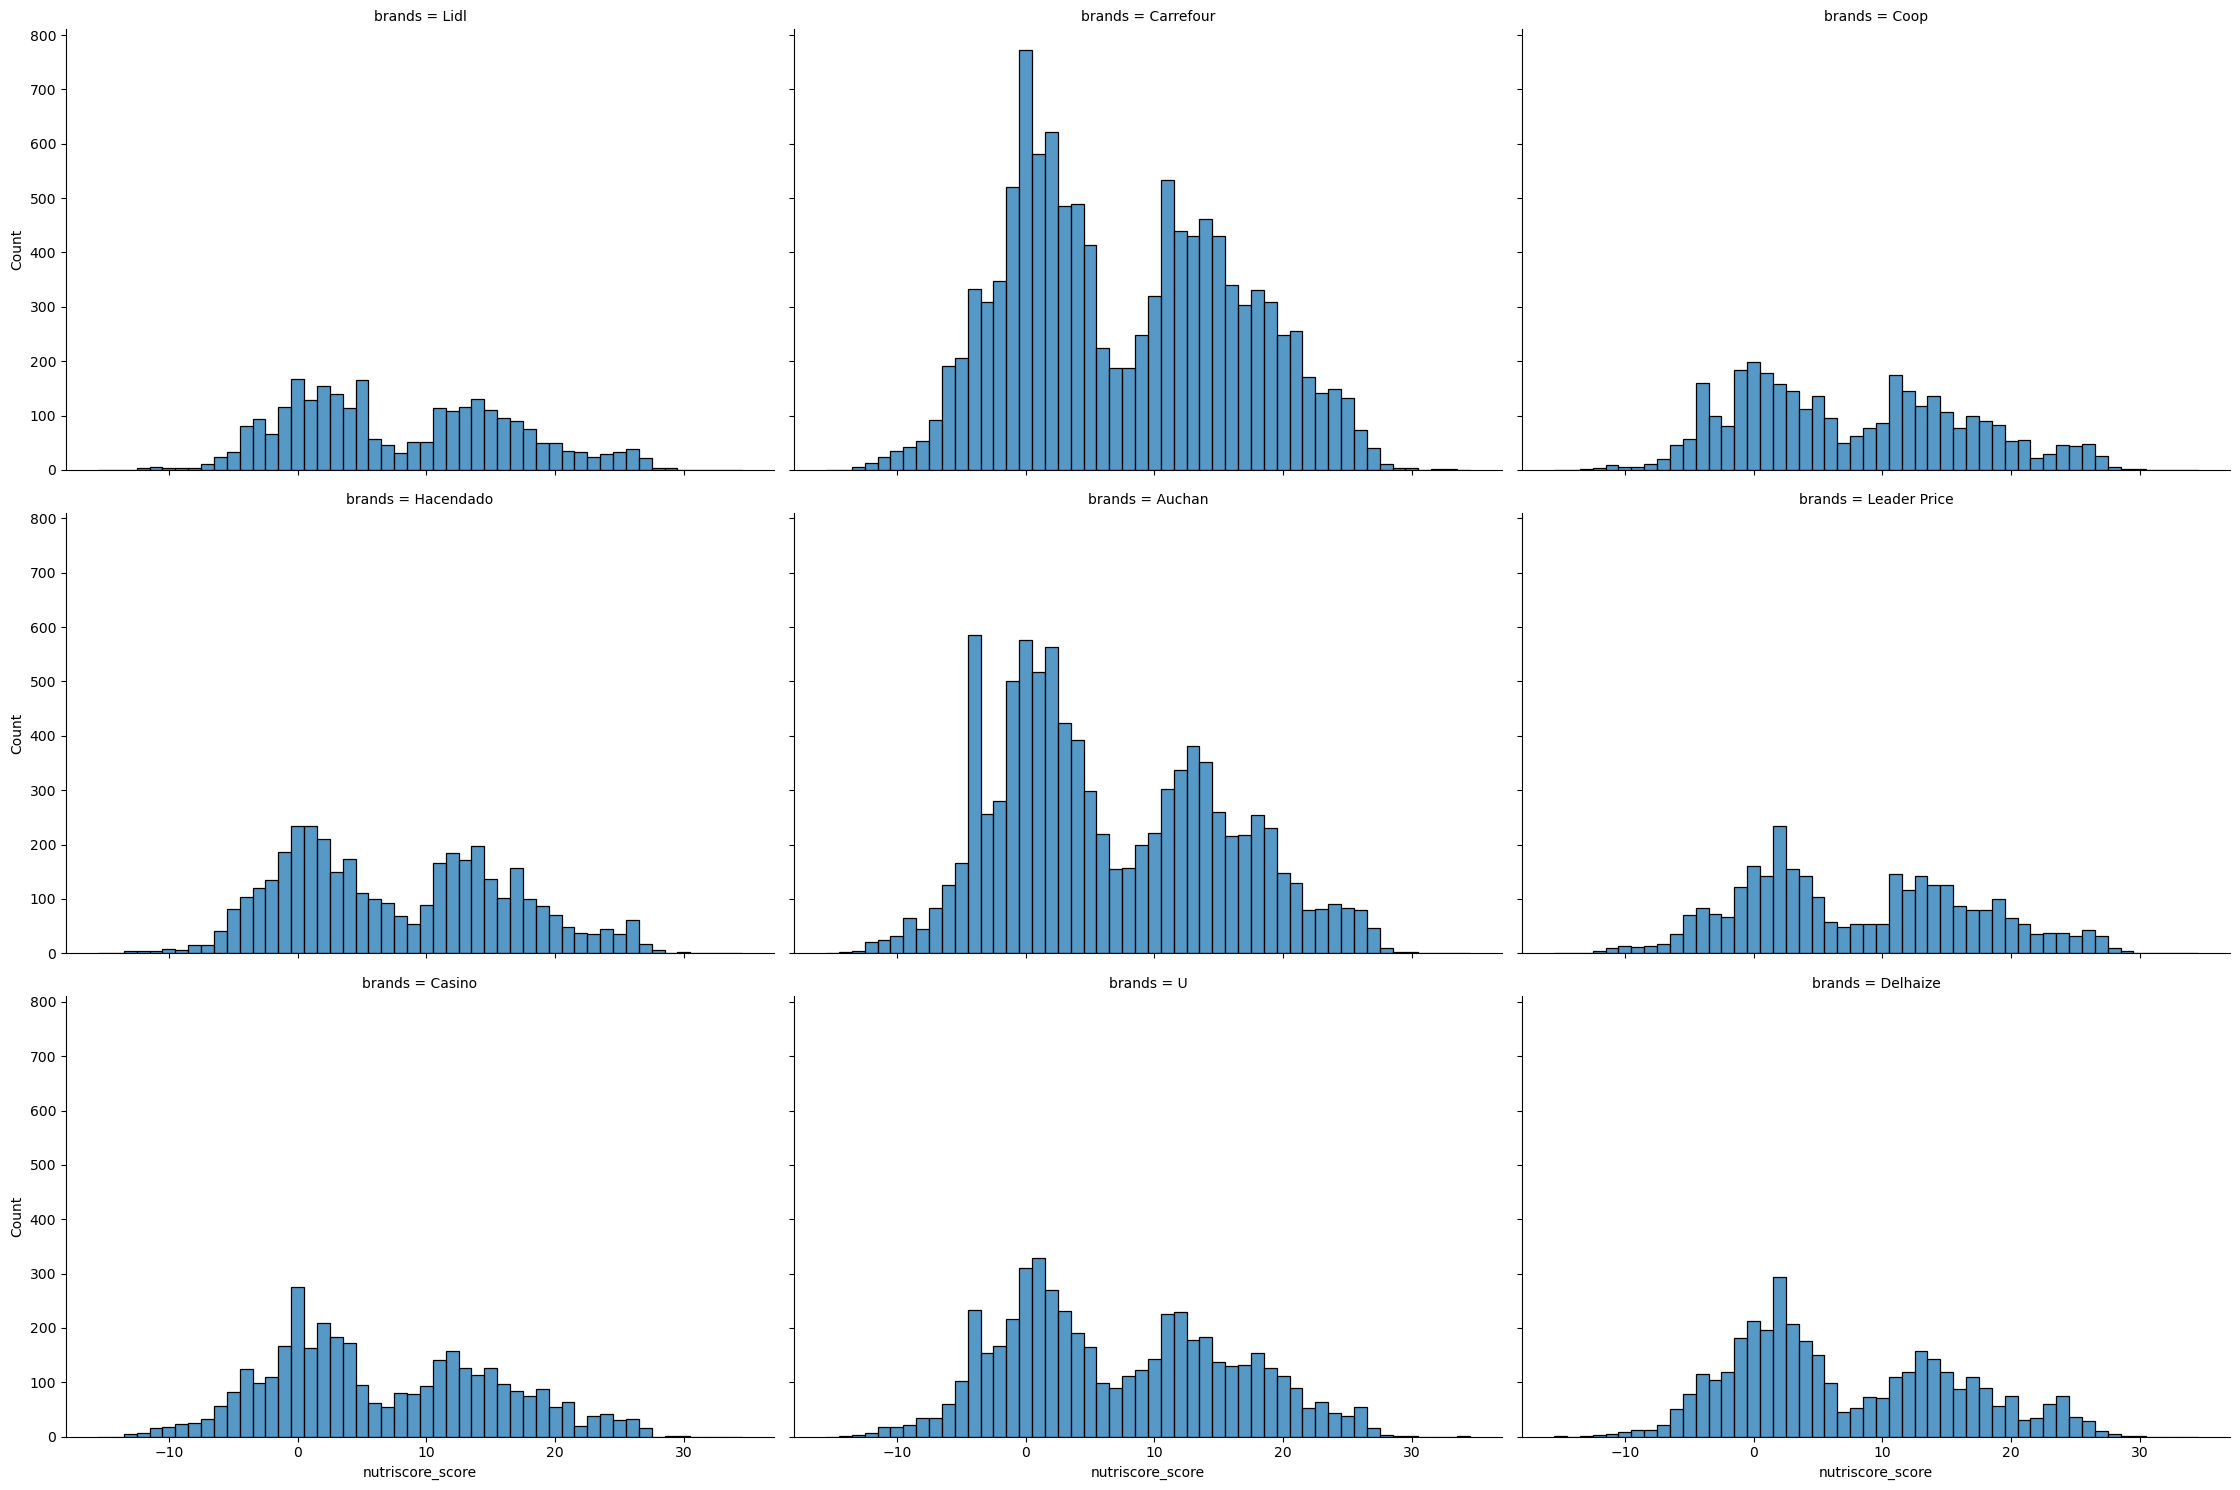

In [16]:
sns.displot(
    data=df_top_brands,
    x="nutriscore_score",
    discrete=True,
    kind="hist",  # default, hence optional
    col="brands",
    col_wrap=3,
    height=5,
    aspect=1.5,
)

The distributions of Nutri-Score scores across brands are quite similar, having two bumps, or [modes](https://en.wikipedia.org/wiki/Mode_(statistics)#Mode_of_a_sample), around 0 and 12.

In other words:
* lots of products have a Nutri-Score score close to 0 or close to 12,
* the further scores go below 0 or above 12, the fewer products,
* there is a "valley" between the two bumps, with fewer products around 6-7.

These are typical of [bimodal distributions](https://en.wikipedia.org/wiki/Multimodal_distribution).

The modes slightly differ between brands though, for instance 0 for Carrefour versus -4 for Auchan.

### Visualizing numerical and categorical data : Nutri-Score score and grade

This is all nice but the Nutri-Score score graphs could be more readable if the bars had the nice colors from the Nutri-Score grade graphs.
As each Nutri-Score score maps to a Nutri-Score grade, this should be straightforward.

`displot` has an argument `hue` that can take a column name (here `'nutriscore_grade'`), and the same `palette` argument as `catplot`.

Let us build the distribution plot of Nutri-Score scores on the whole dataset, with the colors of the Nutri-Score grades (hence `hue` and `palette`), for the whole dataset.

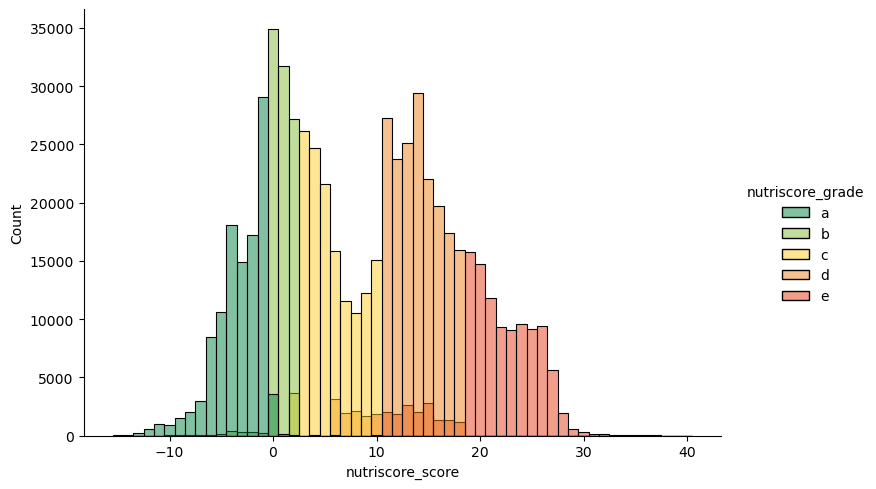

In [17]:
sns.displot(
    data=df,
    x="nutriscore_score",
    discrete=True,
    hue="nutriscore_grade",
    kind="hist",  # default, hence optional
    palette=colors_nutriscore,
    height=5,
    aspect=1.5,
)

You should notice something weird at the bottom of many bars: It seems as if another, more opaque, bar is overlaid.

This might indicate that some products with the same Nutri-Score score have different grades.

We can modify our distribution plot of Nutri-Score scores with colors for grades, so that bars for different Nutri-Score grades are properly stacked rather than (confusingly) laid over one another.

This is done with the parameter `multiple='stack'` (the default value for a [histogram](https://seaborn.pydata.org/generated/seaborn.histplot.html#seaborn.histplot) is `multiple='layer'`).

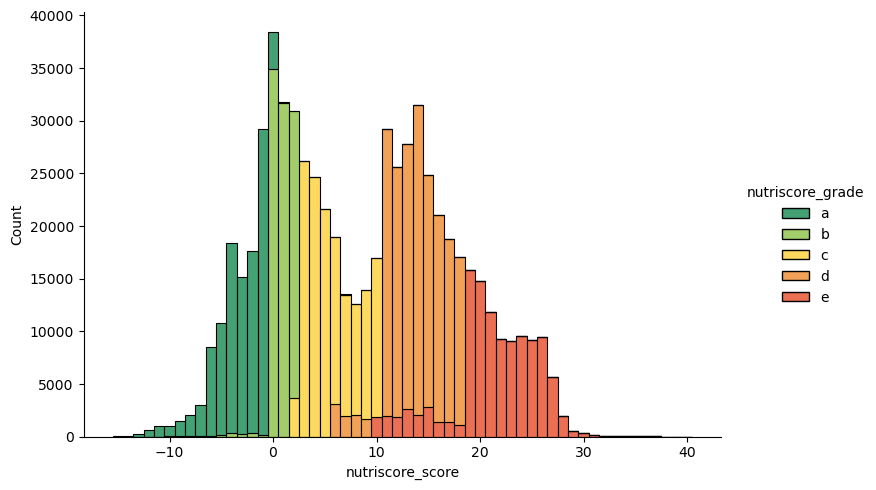

In [18]:
sns.displot(
    data=df,
    x="nutriscore_score",
    discrete=True,
    hue="nutriscore_grade",
    kind="hist",
    multiple="stack",
    palette=colors_nutriscore,
    height=5,
    aspect=1.5,
)

Compare this graph with the previous (unstacked) one.

**Question.** At which scores are stacked bars located? What grades do these bars correspond? How do these values align with your expectations?

**Exercise** Build the distribution plot of Nutri-Score scores, with the colors of the Nutri-Score grades, for all products (foods and beverages together) *for each of the top brands* (defined above).

> **HINT**: Remember to specify `hue`, `palette` and `stack`.

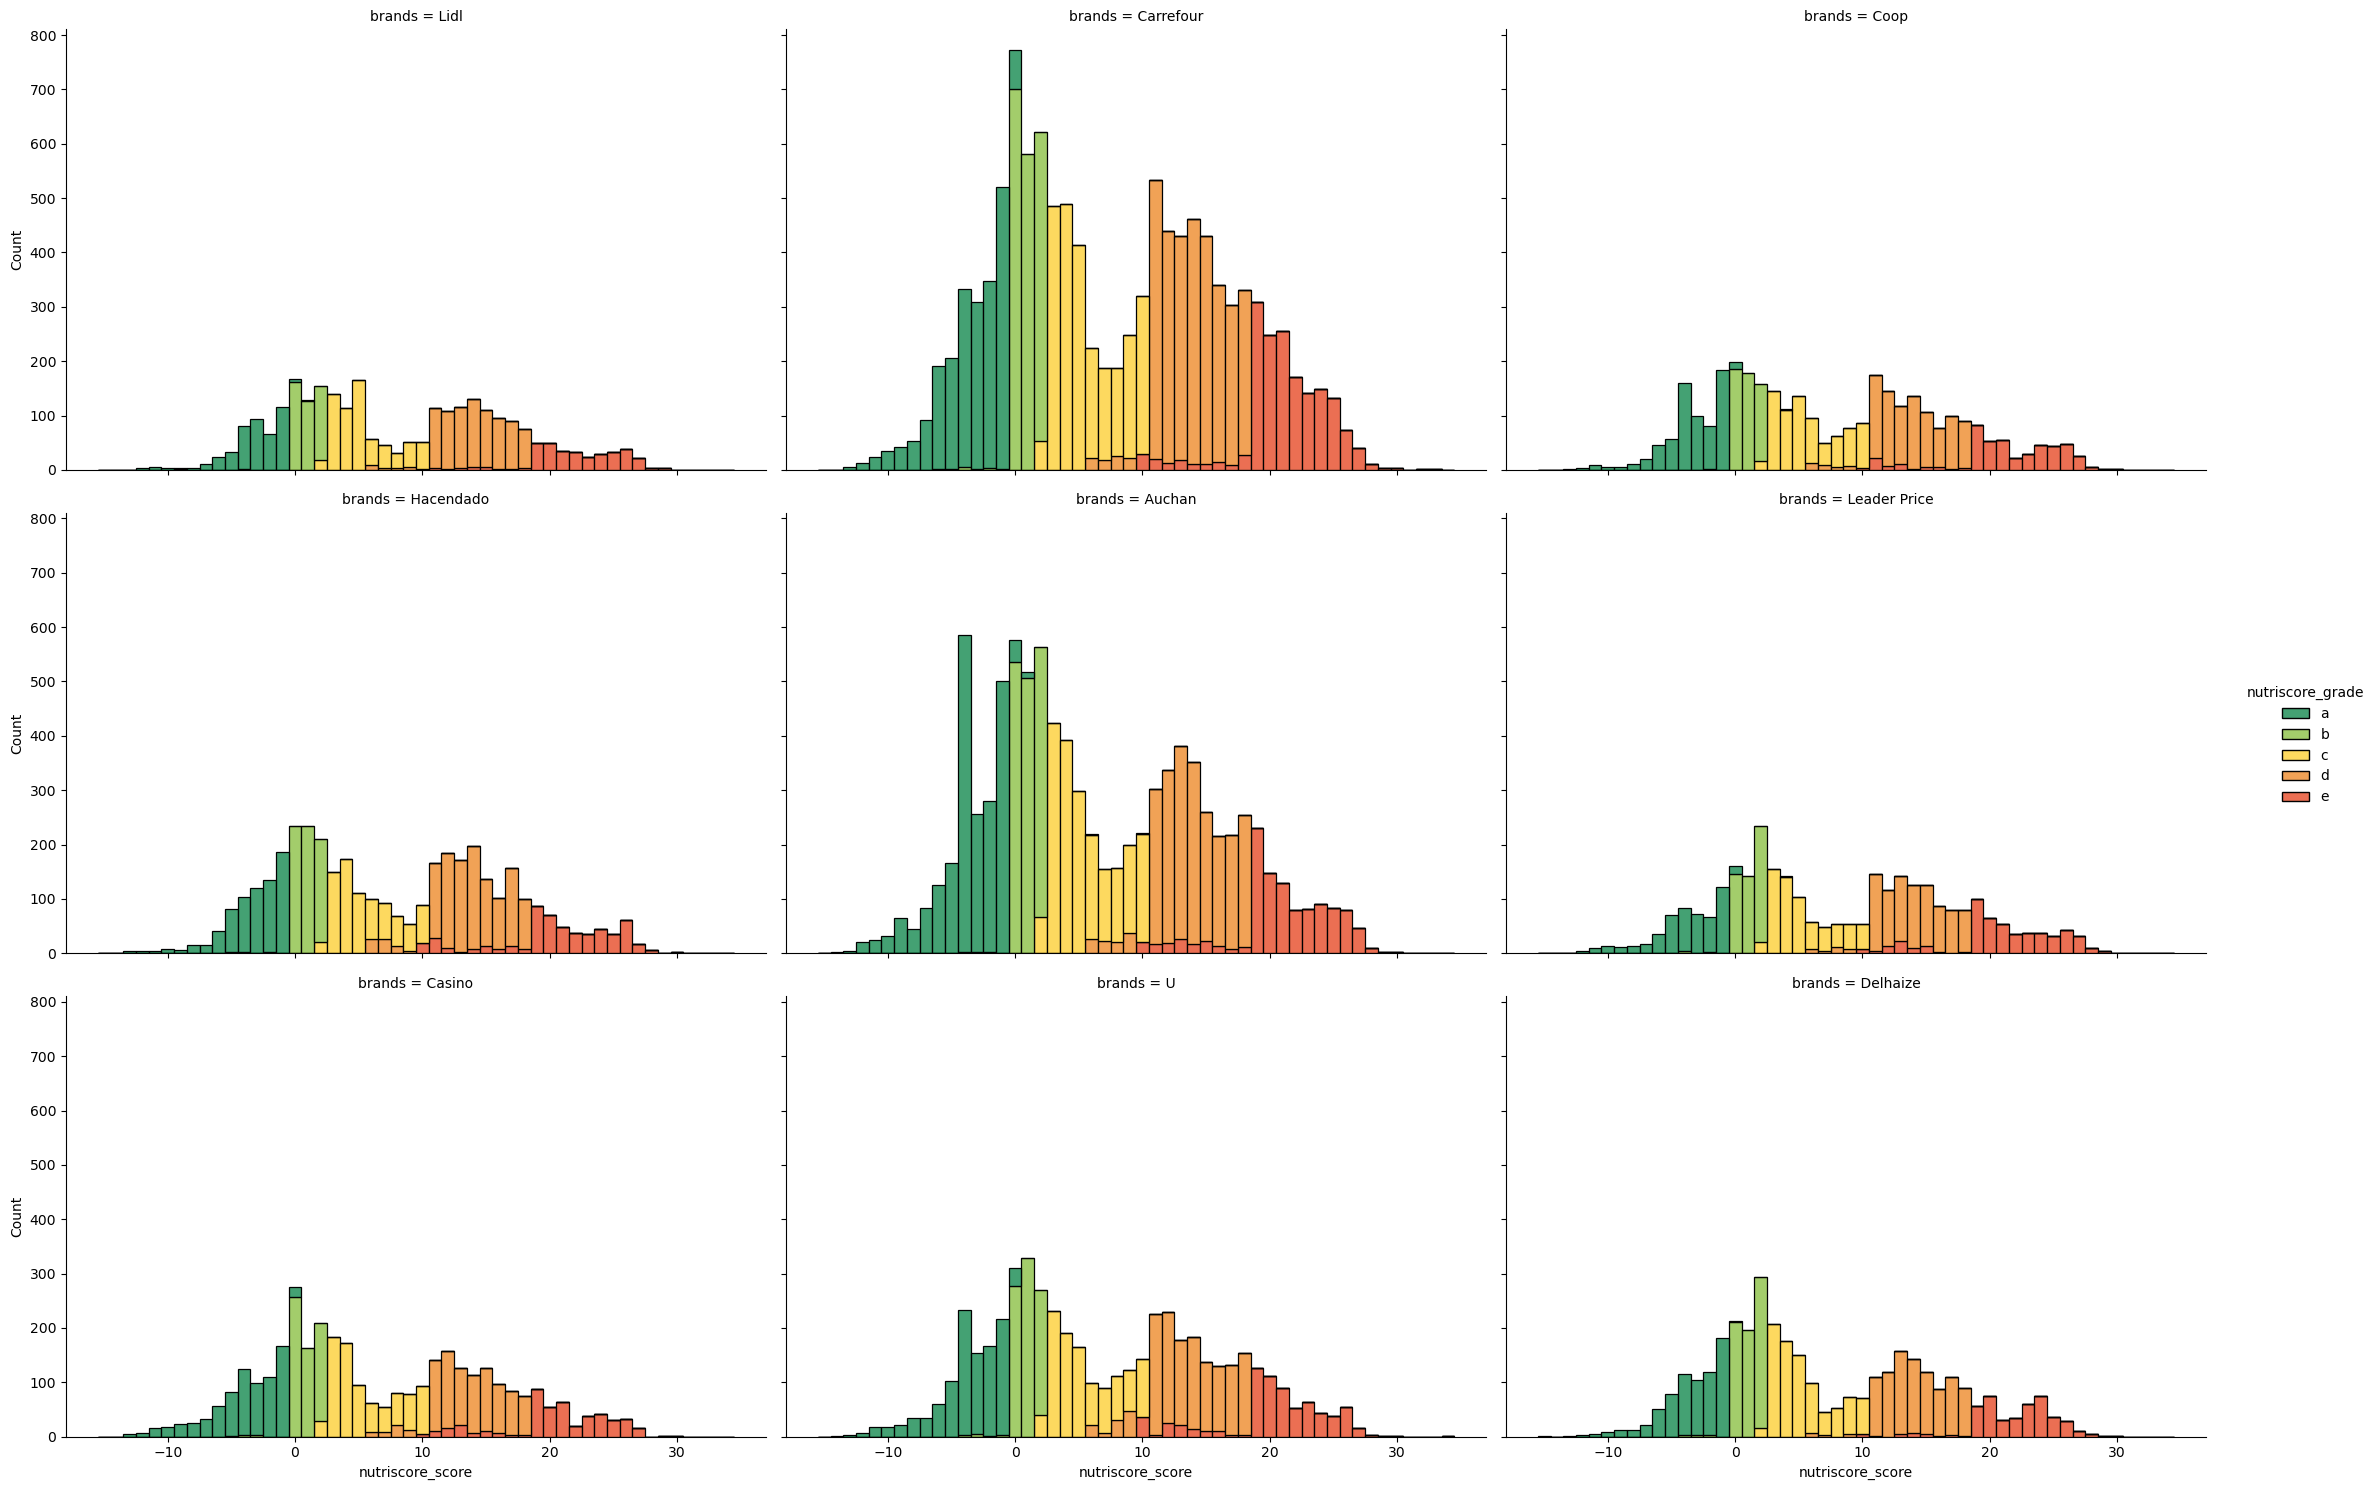

In [19]:
sns.displot(
    data=df_top_brands,
    x="nutriscore_score",
    discrete=True,
    hue="nutriscore_grade",
    kind="hist",
    multiple="stack",
    palette=colors_nutriscore,
    col="brands",
    col_wrap=3,
    height=5,
    aspect=1.5,
)

**Question.** Do you see any difference across brands? What would be your hypotheses to explain this? 

### Using data visualization to assess data quality and revise assumptions

Now that bars are properly stacked, it is clear that some products with the same Nutri-Score score have different Nutri-Score grades.
This discrepancy has an obvious explanation: The thresholds between Nutri-Score grades are different for solid foods and beverages.

We can test our hypothesis by selecting the products that are beverages: We define beverages as the entries whose field `categories_en` contains the string "Beverages". Store the result in a variable called `df_bev`.

In [20]:
df_bev = df[df["categories_en"].str.contains("Beverages")]
df_bev

,code,url,creator,created_datetime,last_modified_datetime,last_modified_by,last_updated_datetime,product_name,generic_name,quantity,...,vitamin-a_100g,vitamin-d_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,potassium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
34,0000731220036,http://world-en.openfoodfacts.org/product/0000731220036/fix,smoothie-app,2023-08-05 17:02:28+00:00,2023-11-05 11:07:02+00:00,teolemon,2024-02-14 04:24:46+00:00,FIX,<NA>,500ml,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
86,0002000003555,http://world-en.openfoodfacts.org/product/0002000003555/ruby-breakfast-tropicana,kiliweb,2018-02-18 15:38:19+00:00,2019-08-23 20:35:58+00:00,roboto-app,2024-02-09 14:49:18+00:00,Ruby breakfast,<NA>,1 L,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14
114,0002399062485,http://world-en.openfoodfacts.org/product/0002399062485/cola-light-k-menu,braaar,2023-01-08 21:27:00+00:00,2023-01-08 21:36:29+00:00,braaar,2024-02-14 01:32:45+00:00,Cola Light,<NA>,33 cl,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1
135,0004411056779,http://world-en.openfoodfacts.org/product/0004411056779/v8-low-sodium-vegetable-cocktail,anonymous-i5bg4zvbke,2023-07-05 14:17:34+00:00,2023-07-20 00:47:33+00:00,anonymous-i5bg4zvbke,2024-02-14 03:59:57+00:00,V8 Low Sodium Vegetable Cocktail,Low Sodium Vegetable Juice,1.89 l,...,NaN,NaN,NaN,NaN,NaN,0.34,NaN,NaN,48.148148,<NA>
137,0004444866666,http://world-en.openfoodfacts.org/product/0004444866666/antioxidant-infusion-costa-rica-clementine-bai,kiliweb,2022-09-04 16:40:48+00:00,2022-09-05 08:21:14+00:00,chevalstar,2024-02-13 23:43:50+00:00,Antioxidant infusion - Costa Rica clementine,<NA>,530 ml,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778708,99863333,http://world-en.openfoodfacts.org/product/99863333/volvic-juicy-fraise-danone,kiliweb,2021-10-16 20:32:22+00:00,2023-02-15 20:13:13+00:00,itsjustruby,2024-02-13 17:47:21+00:00,Volvic Juicy Fraise,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
778709,99877026,http://world-en.openfoodfacts.org/product/99877026/nectar-de-mangue-gilbert,kiliweb,2019-10-20 11:37:00+00:00,2022-02-11 03:29:48+00:00,packbot,2024-02-11 06:44:36+00:00,Nectar de mangue,<NA>,1 l,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.000000,17
778711,9990000003556,http://world-en.openfoodfacts.org/product/9990000003556/fuze-tea-pesca-e-rosa-fuzetea,kiliweb,2022-09-14 12:00:46+00:00,2023-12-05 21:59:12+00:00,alex-off,2024-02-13 23:52:54+00:00,fuze tea pesca e rosa,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
778713,99903336,http://world-en.openfoodfacts.org/product/99903336/jus-multifruits-pressade,kiliweb,2018-07-07 11:10:35+00:00,2022-12-20 11:33:25+00:00,roboto-app,2024-02-10 21:06:07+00:00,Jus multifruits,Nectar multifruit,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.800000,11


You should get 91,299 rows.

We can plot the Nutri-Score scores and grades for the subset of beverages `df_bev`, exactly as we did above for the whole `df`.

> **HINT**: Remember to specify `hue`, `palette`, `stack`.

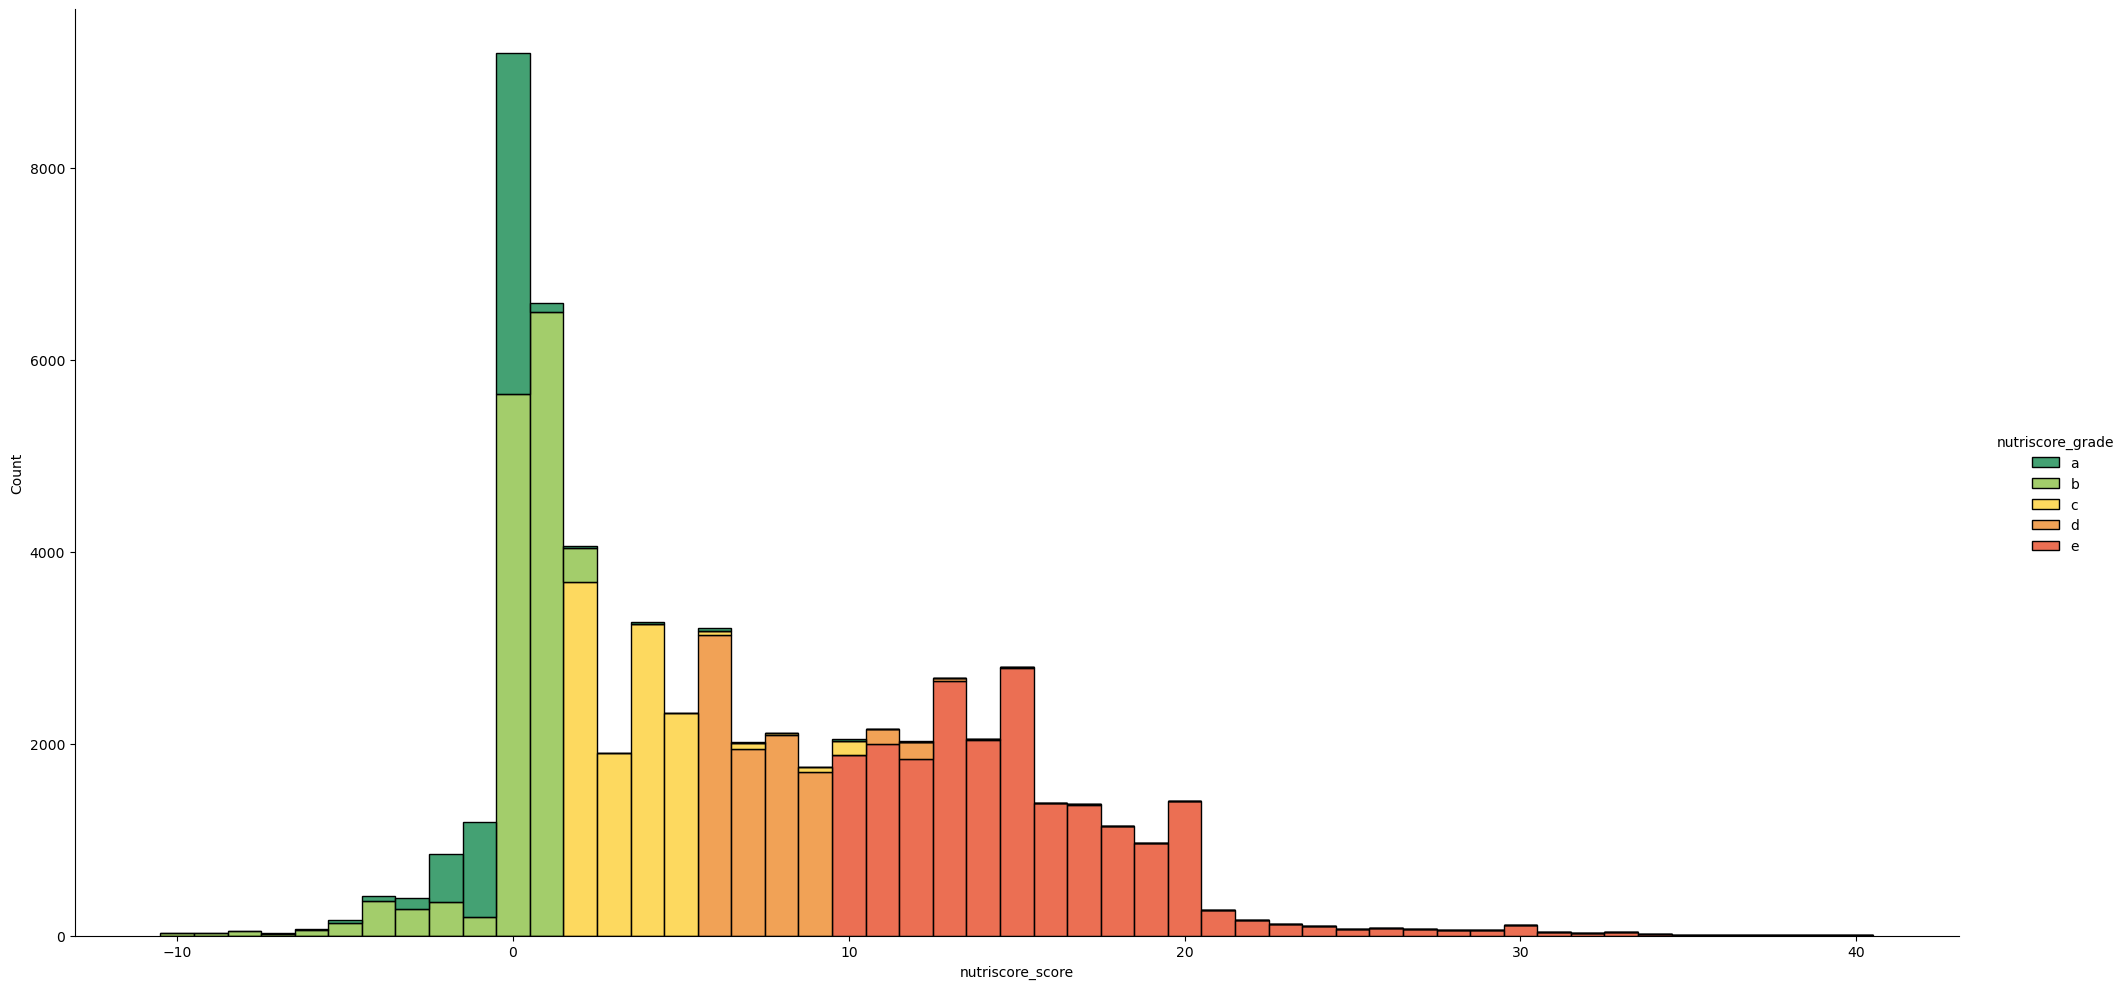

In [29]:
sns.displot(
    data=df_bev,
    x="nutriscore_score",
    discrete=True,
    hue="nutriscore_grade",
    kind="hist",
    multiple="stack",
    palette=colors_nutriscore,
    height=10,
    aspect=2,
)

This is harder to interpret than we expected.

Grade 'c' for beverages is between 3 and 6 (included), yet a fair number of products with scores of 10 are graded 'c': Is this classification correct, or is the data erroneous?
Could they be solid foods?
Have we inadvertently selected non-beverages due to an ill-defined filter?

There are other stacked bars, but some of them are too thin to guess their exact color. are Modifying the aspect or height of the graph, there are other Grade 'b' should not go higher than 2, yet a non-negligible number of products scored 2 are graded 'b'.

We would need to examine the outliers to know if any or all of these leads are correct, but before we do, let us have a closer look at the distribution of Nutri-Score scores for each Nutri-Score grade.

Plot the distribution of Nutri-Score scores for each grade, using a faceted grid across grades (similar to how we did across brands).

>**HINT** Try different values of `col_wrap`, `height` and `aspect` to reveal small bars.

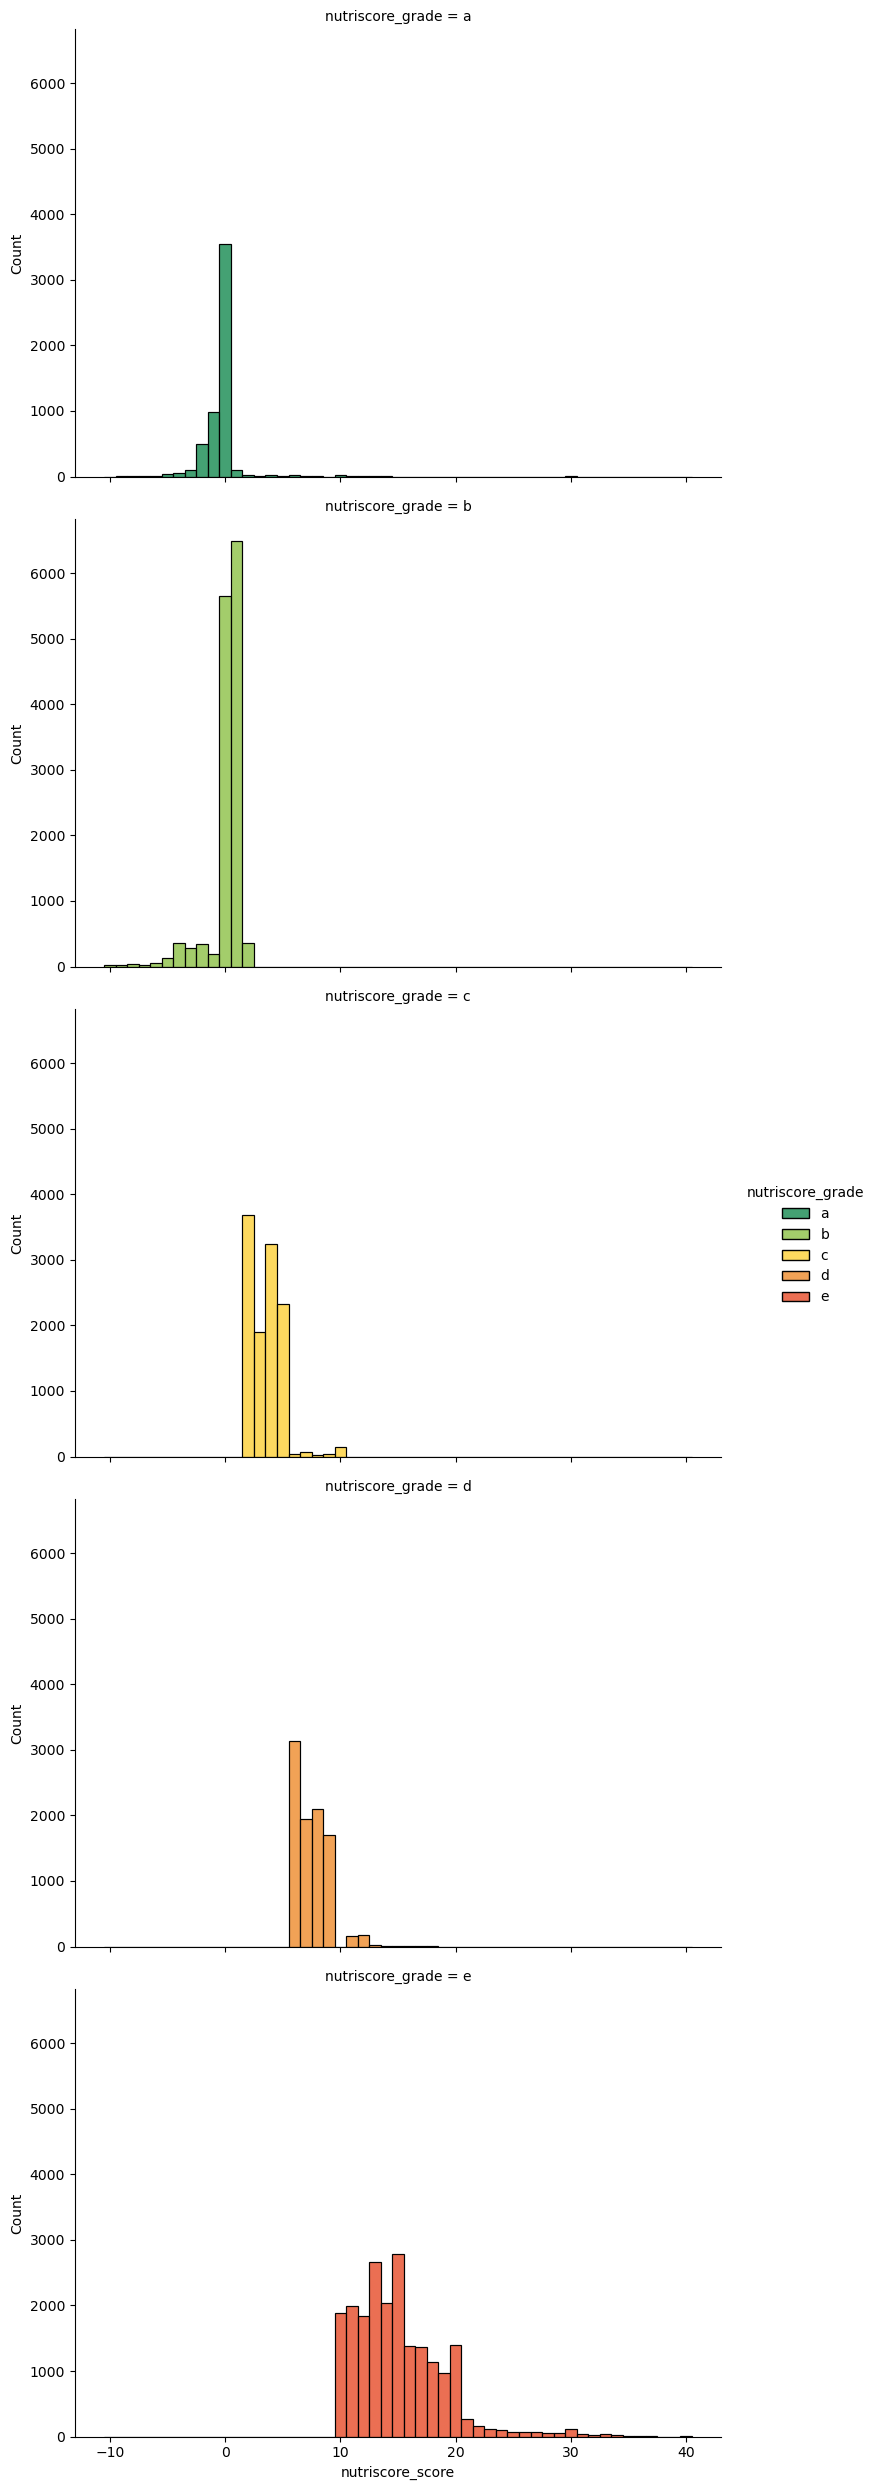

In [31]:
sns.displot(
    data=df_bev,
    x="nutriscore_score",
    discrete=True,
    hue="nutriscore_grade",
    kind="hist",
    multiple="stack",
    palette=colors_nutriscore,
    col="nutriscore_grade",
    col_wrap=1,
    height=5,
    aspect=1.5,
)

There are a few products in our dataset of beverages with Nutri-Score grade 'a', which should be waters, but have a Nutri-Score score of 10.

How is that possible?

In `df_bev`, select products with Nutri-Score score 10 and grade 'a'.
Display the result, look at the first few entries.

In [32]:
df_bev[(df_bev["nutriscore_score"] == 10) & (df_bev["nutriscore_grade"] == "a")]

,code,url,creator,created_datetime,last_modified_datetime,last_modified_by,last_updated_datetime,product_name,generic_name,quantity,...,vitamin-a_100g,vitamin-d_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,potassium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
171113,3254381026402,http://world-en.openfoodfacts.org/product/3254381026402/cristaline-eau-de-source-0-33l-louise,openfoodfacts-contributors,2016-11-16 12:00:56+00:00,2024-04-25 13:04:47+00:00,roboto-app,2024-04-25 13:04:47+00:00,Cristaline Eau De Source 0.33L,CRISTALINE,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
285141,3596710362646,http://world-en.openfoodfacts.org/product/3596710362646/eau-minerale-naturelle-gazeuse-st-jean-auchan,kiliweb,2018-03-27 15:40:35+00:00,2023-08-01 14:47:55+00:00,org-auchan-apaw,NaT,Eau minerale naturelle gazeuse St Jean,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
338575,3838600032414,http://world-en.openfoodfacts.org/product/3838600032414/acqua-donat-magnesio,kiliweb,2021-01-10 19:45:53+00:00,2024-04-30 12:13:59+00:00,nur,2024-04-30 12:13:59+00:00,Acqua Donat Magnesio,<NA>,1 l,...,NaN,NaN,NaN,NaN,NaN,NaN,0.4300,NaN,NaN,10
345128,4001754070109,http://world-en.openfoodfacts.org/product/4001754070109/wasser-fizzy-forstetaler,openfoodfacts-contributors,2020-08-08 07:15:41+00:00,2024-01-14 17:47:40+00:00,bartolomeu,2024-02-13 09:31:37+00:00,Wasser fizzy,<NA>,12pcs,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
346773,4002627801950,http://world-en.openfoodfacts.org/product/4002627801950/naturliches-mineralwasser-medium-ileburger-sachsen...,kiliweb,2021-03-10 16:01:25+00:00,2024-06-08 15:18:45+00:00,showmaster,2024-06-08 15:18:45+00:00,Natürliches Mineralwasser medium,<NA>,"0,75 l",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
348511,4004042016353,http://world-en.openfoodfacts.org/product/4004042016353/mineralwasser-klassisch-hassia,openfoodfacts-contributors,2020-08-08 16:47:15+00:00,2024-01-05 16:40:05+00:00,bartolomeu,2024-02-13 09:31:53+00:00,"Mineralwasser, klassisch",<NA>,0.75l,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
364457,4022569150008,http://world-en.openfoodfacts.org/product/4022569150008/getranke-wasser-st-leonhards-lichtquelle-st-leonha...,kiliweb,2021-03-09 09:43:48+00:00,2024-04-01 20:11:05+00:00,prepperapp,2024-04-01 20:11:05+00:00,Getränke Wasser St. Leonhards Lichtquelle,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
371917,4051913100581,http://world-en.openfoodfacts.org/product/4051913100581/teinacher-clasic,kiliweb,2021-06-17 12:52:31+00:00,2024-07-14 14:25:20+00:00,discostu,2024-07-14 14:25:20+00:00,Teinacher Clasic,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
401054,4100060018321,http://world-en.openfoodfacts.org/product/4100060018321/extaler-classic-wesergold,kiliweb,2021-10-09 15:40:32+00:00,2023-12-28 18:22:19+00:00,bartolomeu,2024-02-13 17:39:34+00:00,Extaler Classic,Mineralwasser,"0,75 l",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,10
435914,4751014941013,http://world-en.openfoodfacts.org/product/4751014941013/quot-venden,smoothie-app,2022-07-26 17:01:10+00:00,2024-04-19 21:52:34+00:00,lnaumka,2024-04-19 21:52:34+00:00,&quot,<NA>,"Good quality 0,75",...,NaN,NaN,NaN,NaN,NaN,0.00400,0.0850,NaN,0.0,10


Our dataset of beverages contains 18 such entries.

Look at the pages for one of them, eg. <http://world-en.openfoodfacts.org/product/3254381026402/cristaline-eau-de-source-0-33l-louise>.

**Question.** Which nutritional value drives a Nutri-Score sore of 10 for this product? Is this value legit or erroneous? What could explain this?

The faceted grid also reveals that a fair number of products of Nutri-Score grade 'c' have a score of '2', which should correspond to grade 'b'.

Select the beverages with Nutri-Score `2` and grade 'c'.

In [34]:
df_bev[(df_bev["nutriscore_score"] == 2) & (df_bev["nutriscore_grade"] == "c")]

,code,url,creator,created_datetime,last_modified_datetime,last_modified_by,last_updated_datetime,product_name,generic_name,quantity,...,vitamin-a_100g,vitamin-d_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,potassium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
137,0004444866666,http://world-en.openfoodfacts.org/product/0004444866666/antioxidant-infusion-costa-rica-clementine-bai,kiliweb,2022-09-04 16:40:48+00:00,2022-09-05 08:21:14+00:00,chevalstar,2024-02-13 23:43:50+00:00,Antioxidant infusion - Costa Rica clementine,<NA>,530 ml,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1452,0011110507082,http://world-en.openfoodfacts.org/product/0011110507082/ruby-red-pulp-free-grapefruit-juice-kroger,org-database-usda,2020-04-23 18:00:03+00:00,2023-01-23 21:55:58+00:00,wolfgang8741,2024-02-12 17:38:55+00:00,Ruby red pulp-free grapefruit juice,<NA>,<NA>,...,NaN,NaN,0.0250,NaN,NaN,0.125,0.008,0.00021,100.000000,2
2721,0012000012730,http://world-en.openfoodfacts.org/product/0012000012730/diet-iced-tea-lipton,usda-ndb-import,2017-03-10 09:51:42+00:00,2022-04-25 23:35:21+00:00,kiliweb,2024-02-09 15:32:42+00:00,Diet iced tea,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.100911,2
2722,0012000012785,http://world-en.openfoodfacts.org/product/0012000012785/diet-green-tea-citrus-lipton,usda-ndb-import,2017-03-10 09:51:42+00:00,2022-02-10 21:11:22+00:00,packbot,2024-02-09 15:32:43+00:00,Diet Green Tea Citrus,<NA>,591 ml,...,NaN,NaN,0.1500,NaN,NaN,NaN,NaN,NaN,0.000000,2
2723,0012000012792,http://world-en.openfoodfacts.org/product/0012000012792/lipton-diet-green-tea-with-citrus-pack,usda-ndb-import,2017-03-10 09:51:42+00:00,2022-05-12 13:39:13+00:00,kiliweb,2024-02-09 15:32:43+00:00,Lipton diet green tea with citrus pack,<NA>,<NA>,...,NaN,NaN,0.0252,NaN,NaN,NaN,NaN,NaN,0.051082,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777043,9421006043470,http://world-en.openfoodfacts.org/product/9421006043470/charlie-s-lemonade,openfoodfacts-contributors,2018-12-09 02:11:06+00:00,2023-03-25 05:57:52+00:00,kiliweb,2024-02-10 23:37:21+00:00,Charlie's Lemonade,<NA>,2l,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
777264,9421901214289,http://world-en.openfoodfacts.org/product/9421901214289/glow-bright-simple-juicery,openfoodfacts-contributors,2021-02-25 05:40:10+00:00,2022-01-21 01:03:43+00:00,ecoscore-impact-estimator,2024-02-13 12:48:12+00:00,Glow bright,<NA>,325ml,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.000000,2
777303,9421902262456,http://world-en.openfoodfacts.org/product/9421902262456/kombucha-probiotic-drink-mix-lemon-ginger-flavour-...,erycm,2023-08-09 03:57:10+00:00,2023-08-19 20:40:41+00:00,erycm,2024-02-14 04:27:36+00:00,Kombucha Probiotic Drink Mix Lemon & Ginger Flavour,<NA>,75 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,2
777398,9421905073615,http://world-en.openfoodfacts.org/product/9421905073615/hydrate-no-ugly,kiliweb,2022-05-14 22:16:59+00:00,2024-04-21 09:27:01+00:00,lcmortensen,2024-04-21 09:27:01+00:00,Hydrate,<NA>,250 ml,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


There are 3687 such products, among which <https://world.openfoodfacts.org/product/9421006043470/charlie-s-lemonade>.

**Question.** What is the Nutri-Score grade displayed on this product page? Does this match the value in our dataset?
What is the Nutri-Score score for this product according to its product page? Does this match the value in our dataset?

>**HINT** The product pages on the Open Food Facts website contain lots of panels that are "folded" by default.

#### Sources of inconsistencies

Two main factors can explain inconsistencies between the database, the product page, and the product image:
1. While the Nutri-Score grade is displayed on the product, the underlying Nutri-Score score is not.
Therefore, Open Food Facts automatically re-estimates the Nutri-Score score from the nutritional values and relevant (estimated) proportion of certain ingredients.
Part of this information is hard to retrieve though, like the proportion of fruits, vegetables and nuts in a product, or not always displayed like its fiber content.
As a consequence, the Nutri-Score score in Open Food Facts is a best estimate, given available information, of the true Nutri-Score score, and might not exactly match the Nutri-Score grade displayed on the product packaging.
2. The Nutri-Score algorithm has been updated to better match the available scientific evidence, most recently in 2023. The Open Food Facts website displays Nutri-Score scores and grades computed using the updated algorithm from 2023.
However, most database entries still contain the grades that were displayed on food packages until recently, which correspond to the result of the former algorithm (2017).

We cannot do anything about these inconsistencies in the scope of this course, but this is an important reminder that data can be erroneous, inconsistent, or incomplete. 

Any data-driven analysis or study should properly address issues of data quality, in order to draw solid conclusions.

## Nutri-Score vs Nova

The Nutri-Score and [Nova groups](https://world.openfoodfacts.org/nova) capture different aspects of the impact of food products on health.
Are they correlated ?

In [11]:
# we will use the color palette for the NOVA groups
# couleurs NOVA
colors_nova = {
    "1": "#00aa00",
    "2": "#ffcc00",
    "3": "#ff6600",
    "4": "#ff0000",
}

### Visualizing two categorical variables

We will first plot, for each Nutri-Score grade, the count of products with this Nutri-Score grade and each of the NOVA groups.

(Note that we work on the entire dataset `df` again, after our detour through beverages.)

> **HINT**: Remember to specify the `hue` and `palette`.

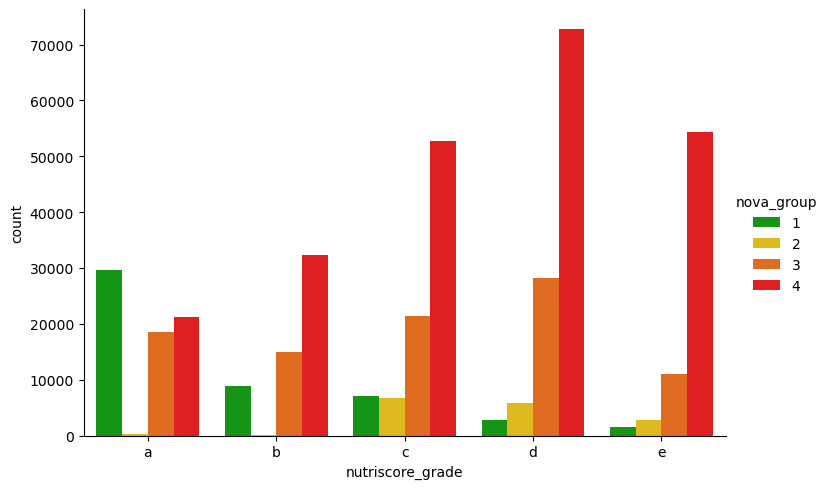

In [41]:
sns.catplot(
    data=df,
    x="nutriscore_grade",
    hue="nova_group",
    kind="count",
    palette=colors_nova,
    height=5,
    aspect=1.5,
)

The NOVA group 4 is dominant in all Nutri-Score grades except the healthiest one (group 'a').
This is not so surprising as, by construction, the Nutri-Score and NOVA groups capture different aspects.

Now do the plot the other way round : for each NOVA group, plot the number of products with this NOVA group and each of the Nutri-Score grades. Do not forget to use the right color palette.

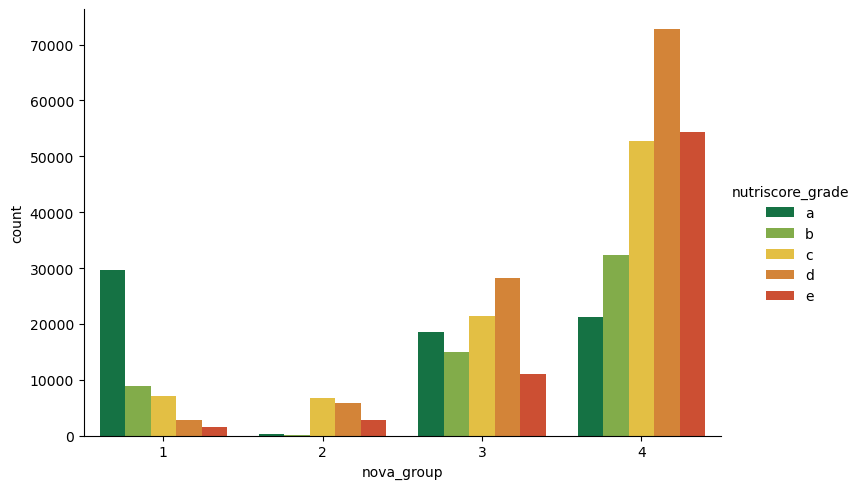

In [42]:
sns.catplot(
    data=df,
    x="nova_group",
    hue="nutriscore_grade",
    kind="count",
    palette=colors_nutriscore,
    height=5,
    aspect=1.5,
)

A majority of the products in the NOVA group 1 have the Nutri-Score grade 'a'.
In other words: Most raw products (NOVA group 1) are also nutritionally healthy (Nutri-Score 'a').
This makes sense, intuitively.


NOVA group 2 contains very few products, mostly from Nutri-Score grades 'c', 'd' and 'e'.
It becomes hard to have an intuitive explanation for why that is, or even which products are in NOVA group 2.

Select products with NOVA group 2 and Nutri-Score grade "a", and display the last 3 products.

In [54]:
df[(df["nova_group"] == "2") & (df["nutriscore_grade"] == "a")].tail(n=3)

,code,url,creator,created_datetime,last_modified_datetime,last_modified_by,last_updated_datetime,product_name,generic_name,quantity,...,vitamin-a_100g,vitamin-d_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,potassium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
776780,9415795000608,http://world-en.openfoodfacts.org/product/9415795000608/canola-oil-pacific-crown,waistline-app,2023-12-23 03:57:25+00:00,2024-06-02 05:47:02+00:00,naruyoko,2024-06-02 05:47:02+00:00,Canola oil,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3
777284,9421901881160,http://world-en.openfoodfacts.org/product/9421901881160/pic-s-really-good-peanut-butter-smooth,usda-ndb-import,2017-03-09 22:06:38+00:00,2024-06-23 02:36:35+00:00,macrofactor,2024-06-23 02:36:35+00:00,Pic's Really Good Peanut Butter Smooth,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.0,-6
777285,9421901881177,http://world-en.openfoodfacts.org/product/9421901881177/pic-s-really-good-peanut-butter-smooth-no-salt-pics,usda-ndb-import,2017-03-09 22:06:39+00:00,2024-06-22 23:58:27+00:00,macrofactor,2024-06-22 23:58:27+00:00,Pic's Really Good Peanut Butter Smooth No Salt,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,-7


Examples of selected products are:
- [peanut butter](https://world.openfoodfacts.org/product/9421901881177/pic-s-really-good-peanut-butter-smooth-no-salt-pics) made of nothing but peanuts,
- [canola oil](http://world-en.openfoodfacts.org/product/9415795000608/canola-oil-pacific-crown), for which the website displays an updated Nutri-Score "b".

Select products with NOVA group 2 and Nutri-Score grade "e", and display the last 3 products.

In [55]:
df[(df["nova_group"] == "2") & (df["nutriscore_grade"] == "e")].tail(n=3)

,code,url,creator,created_datetime,last_modified_datetime,last_modified_by,last_updated_datetime,product_name,generic_name,quantity,...,vitamin-a_100g,vitamin-d_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,potassium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
777806,9555640202365,http://world-en.openfoodfacts.org/product/9555640202365/organic-virgin-coconut-oil-opika,kiliweb,2018-10-10 01:18:58+00:00,2022-02-11 05:57:09+00:00,packbot,2024-02-10 22:10:55+00:00,Organic Virgin Coconut Oil,Huile d'olive vierge extra - Organic Virgin Coconut Oil,1 L,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,20
777935,9556041130943,http://world-en.openfoodfacts.org/product/9556041130943/huile-de-coco-vierge-ayam,openfoodfacts-contributors,2016-12-05 18:18:04+00:00,2022-02-10 14:42:42+00:00,packbot,2024-02-10 21:04:58+00:00,Huile de coco vierge,Huile de coco vierge biologique,165 ml,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,20
778498,9782266323512,http://world-en.openfoodfacts.org/product/9782266323512/huile-de-coco-vierges-biologique-kirkland,kiliweb,2022-12-30 10:44:34+00:00,2023-08-21 06:31:31+00:00,teolemon,2024-02-14 01:23:45+00:00,Huile de coco vierges biologique,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20


The displayed products are coconut oils, such as [this one](https://world.openfoodfacts.org/product/9555640202365/organic-virgin-coconut-oil-opika), which are very high in saturated fats and therefore not recommended as main cooking fats.

Coconut oil is an example of a product that is not heavily processed (NOVA group 2) but not considered very healthy (Nutri-Score "e").

The converse is true: The mode of NOVA groups 3 and 4 is Nutri-Score grade 'd', but both NOVA groups contain a non-negligible number of products with Nutri-Score 'a'.
A fair number of products that are heavily processed are nevertheless considered healthy.

Feel free to look them up in the dataset.


### Visualizing numerical and categorical data (again)

Let us see if there is a clearer relationship between Nutri-Score *scores* and NOVA groups.

> **Hint** : use the same `displot` function as earlier but replace arguments specific to Nutri-Score grades with their equivalent for NOVA groups.

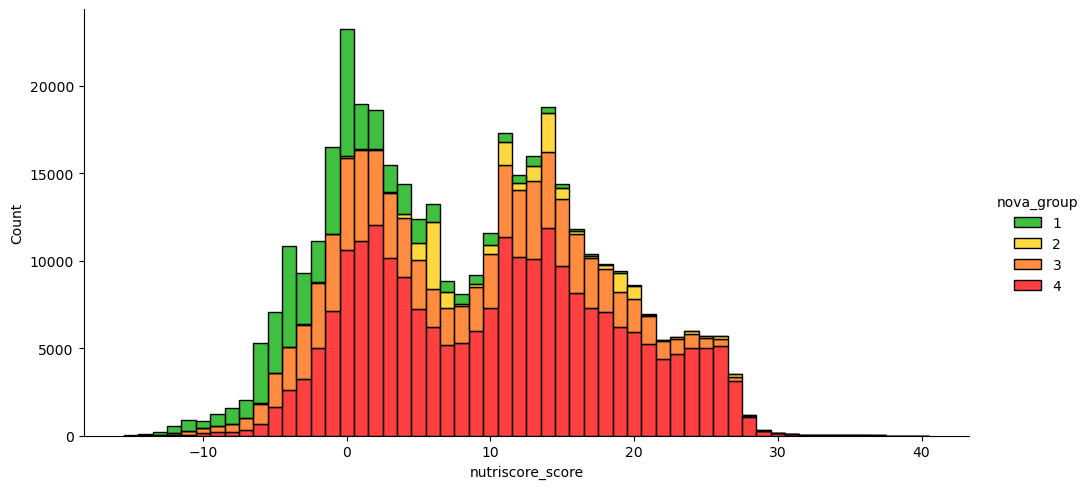

In [56]:
sns.displot(
    data=df,
    x="nutriscore_score",
    discrete=True,
    hue="nova_group",
    kind="hist",
    multiple="stack",
    palette=colors_nova,
    height=5,
    aspect=2,
)

The NOVA group 4 is largely dominant for all products with a Nutri-Score score greater than or equal to -3, which is lower than the thresholds between Nutri-Score grades 'a' and 'b' for both solid foods and beverages.

All these graphs confirm that Nutri-Score and NOVA are only loosely correlated, because they capture different information, and that the NOVA groups are heavily imbalanced.

The latest graph alone hints that Nutri-Score scores enable finer-grained analyses than Nutri-Score grades.

**Exercise.** Build a displot that shows:
* for each NOVA group,
* the histogram distribution of Nutri-Score scores,
* with colored stacked bars for the Nutri-Score grades.

> **HINT**: You need to specify the right `palette`.

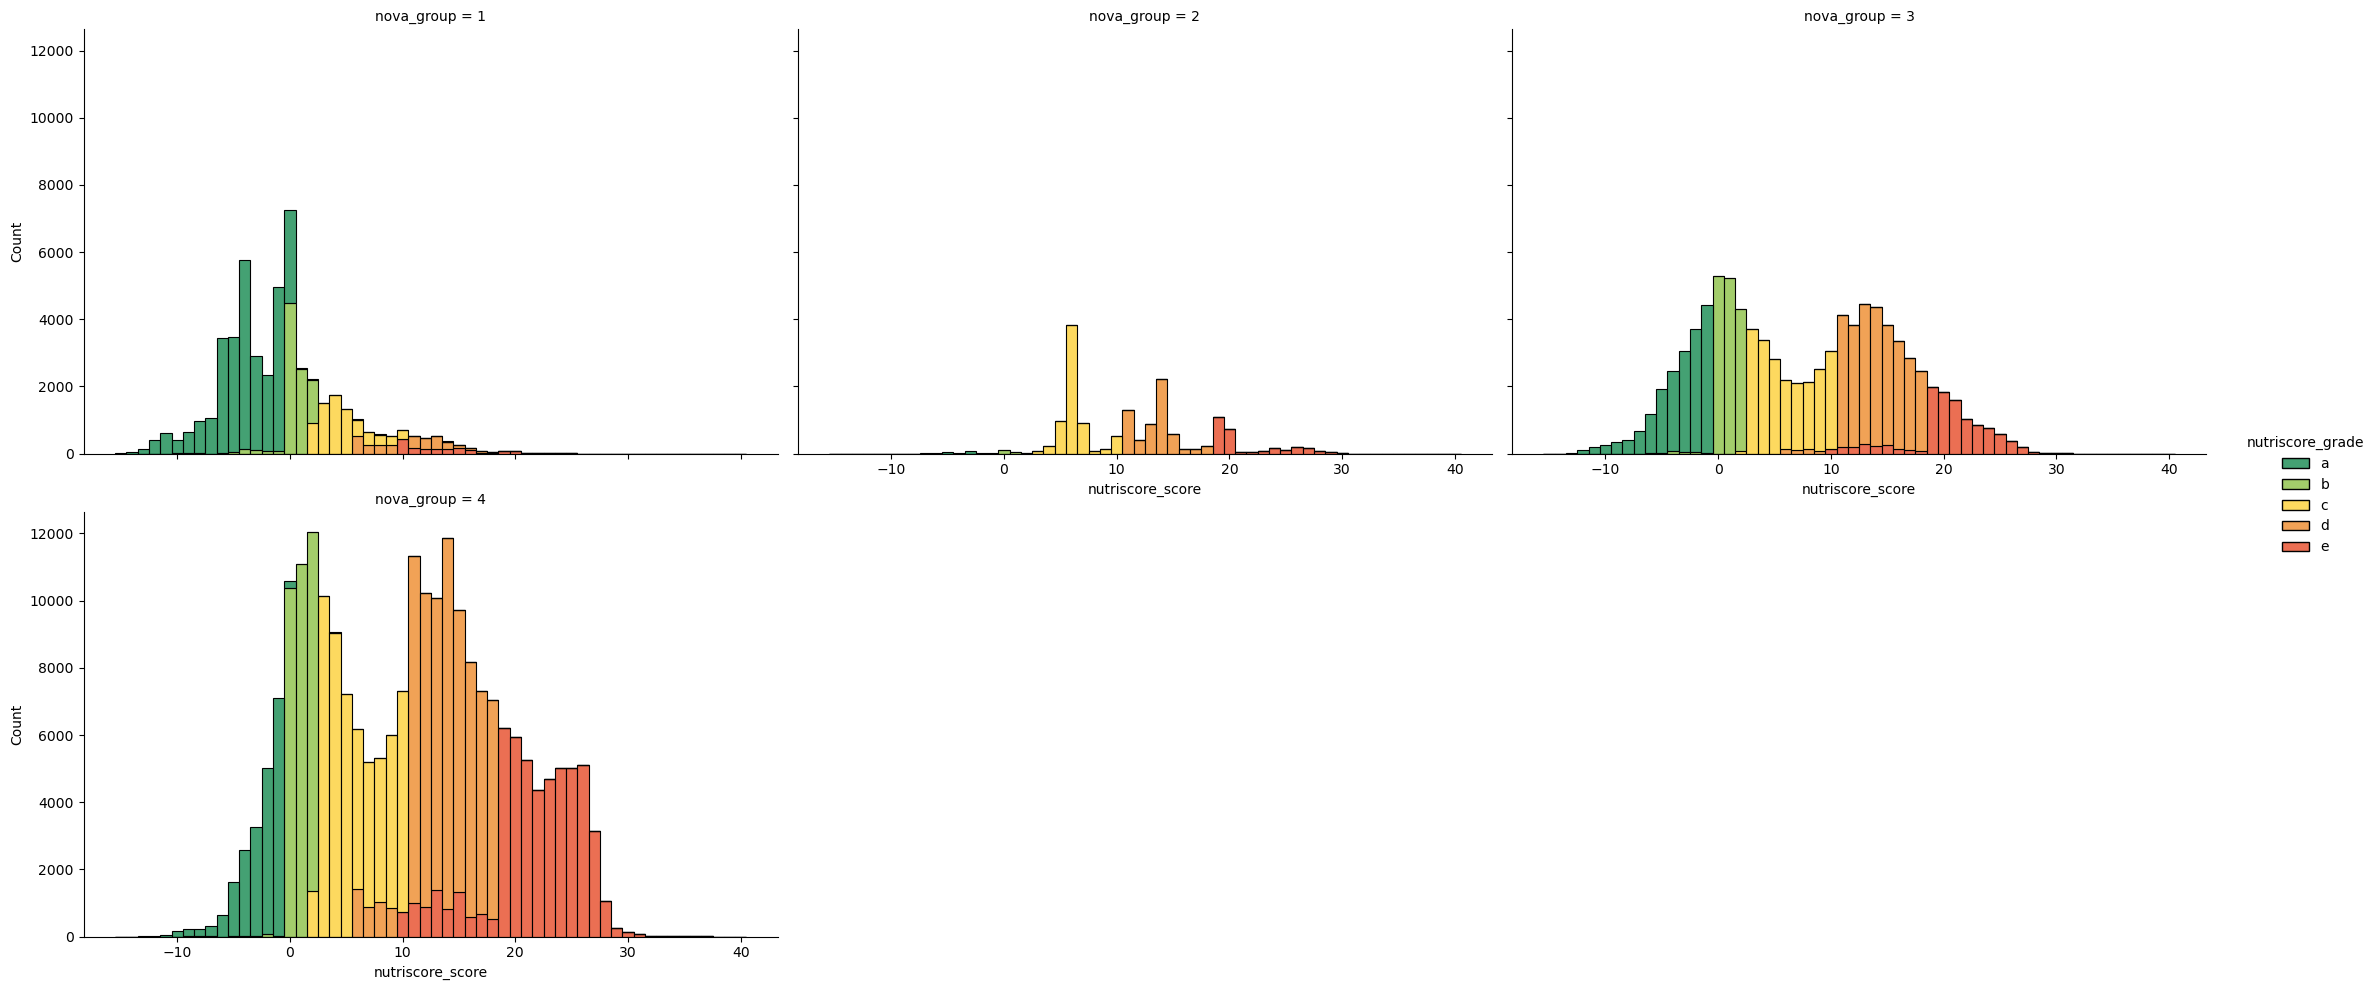

In [57]:
sns.displot(
    data=df,
    x="nutriscore_score",
    discrete=True,
    hue="nutriscore_grade",
    kind="hist",
    multiple="stack",
    palette=colors_nutriscore,
    col="nova_group",
    col_wrap=3,
    height=5,
    aspect=1.5,
)

* NOVA group 4 contains the highest number of products, across the entire distribution of Nutri-Score scores.
* NOVA group 2 contains very few products, mostly with quite high Nutri-Score scores.

Does NOVA group 2 consist of a few categories of products with high homogeneous Nutri-Score scores (coconut oil being one of these groups)?

You can explore NOVA group 2 in more detail to find out, and let us know your findings !

**Bonus exercise.** Try and come up with a graph built the other way round, ie. a catplot of NOVA groups that displays distributions of Nutri-Score scores.

> **HINT** The categorical variable (here the NOVA group) can be specified as `x` or `y`. Try both options and keep the one that you find more readable.

> **HINT** You could try different kinds of catplot but we have (a) many observations and (b) missing values, so you should use the distribution plots (`box` or `boxen`).

> **HINT** Specifying a `hue` and `palette` will improve the looks of your graph. Use the `palette` that best suits your graph.

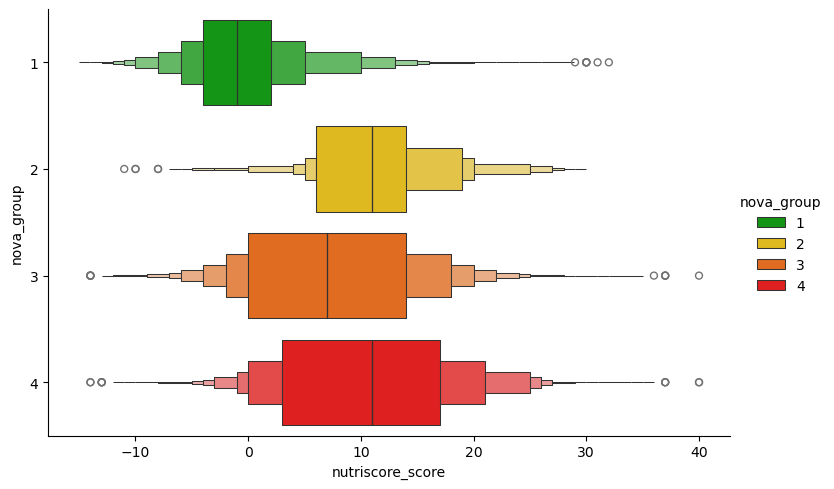

In [59]:
sns.catplot(
    data=df,
    x="nutriscore_score",
    y="nova_group",
    hue="nova_group",
    kind="boxen",
    palette=colors_nova,
    height=5,
    aspect=1.5,
)

The general tendency is that the distribution of Nutri-Score scores shifts to the right as the NOVA group increases.

The NOVA group '2' is an exception: The distribution of its Nutri-Score scores is "higher" than we would have expected.

Build a more detailed variant of this graph: Use the Nutri-Score grade as a `hue` variable.

> **HINT** You will need to change the `palette` so that it can apply to the `hue` variable.

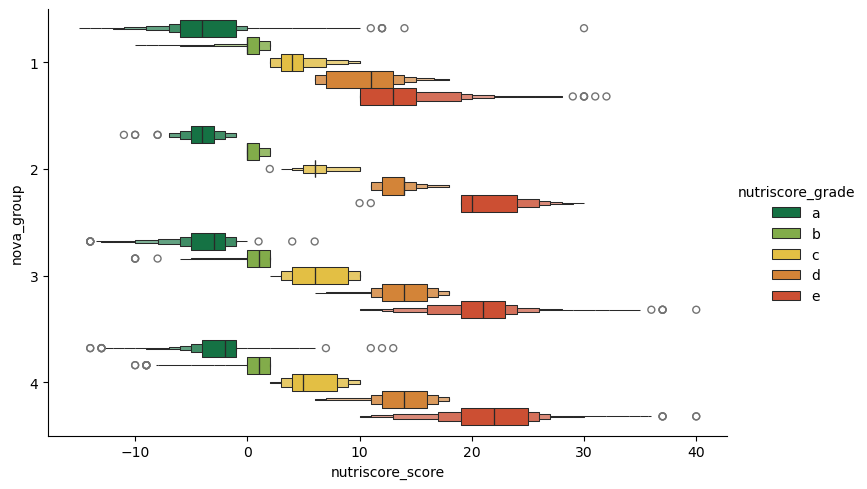

In [60]:
sns.catplot(
    data=df,
    x="nutriscore_score",
    y="nova_group",
    hue="nutriscore_grade",
    kind="boxen",
    palette=colors_nutriscore,
    height=5,
    aspect=1.5,
)

## Eco-Score

In January 2021, OpenFoodFacts and a number of actors launched the [Eco-Score (French)](https://docs.score-environnemental.com/):
  * [announcement (French)](https://fr.blog.openfoodfacts.org/news/lancement-de-l-eco-score-la-note-environnementale-des-produits-alimentaires)
  * [description (French)](https://fr.openfoodfacts.org/eco-score-l-impact-environnemental-des-produits-alimentaires)


Eco-Score grades range from A (good) to E (bad), with the same color palette as the Nutri-Score (green to red).

Build for the Eco-Score (score and grade) the same graphs as the ones we produced for the Nutri-Score.

> **HINT**: The corresponding columns are named `ecoscore_score` and `ecoscore_grade`. Use the Nutri-Score palette.

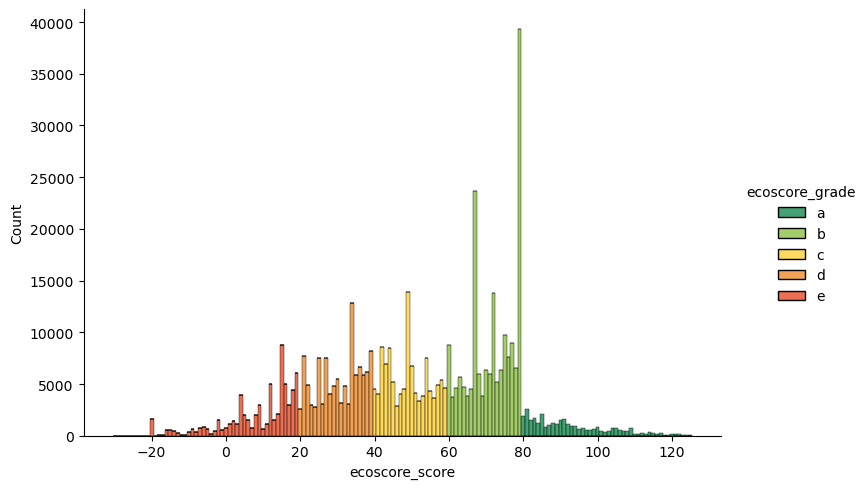

In [62]:
sns.displot(
    data=df,
    x="ecoscore_score",
    discrete=True,
    hue="ecoscore_grade",
    kind="hist",
    multiple="stack",
    palette=colors_nutriscore,
    height=5,
    aspect=1.5,
)

This graph reveals something unexpected (unless you read in detail about the Eco-Score): Products with a high Eco-Score score have the best Eco-Score grade, which is the opposite of Nutri-Scores (negative is good, positive bad).

In [ ]:
# etc.

We can also compare Nutri-Score scores and Eco-Score scores, with a [scatter plot](https://seaborn.pydata.org/tutorial/relational.html#relating-variables-with-scatter-plots).

Scatter plots enable to visualize the joint distribution of two variables, using a cloud of points where each variable is a coordinate in the 2 dimensional plane.

> **HINT**: You need to build a relational plot `relplot` of kind `scatter`.

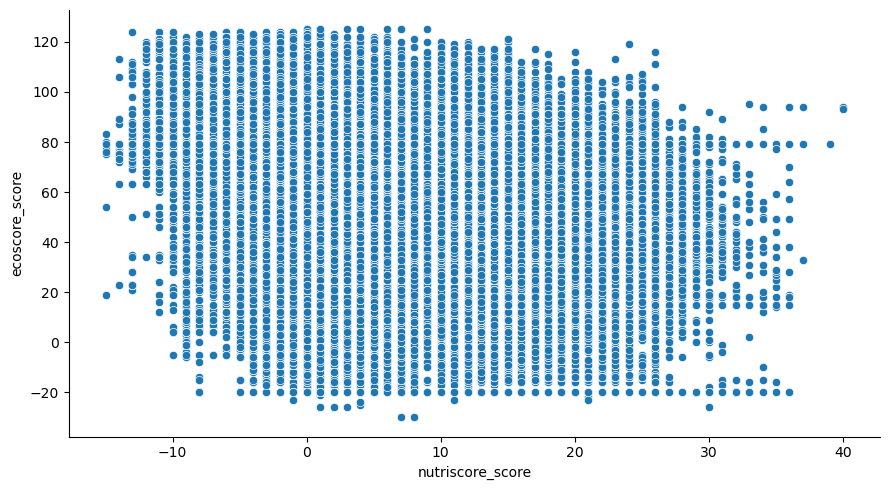

In [63]:
sns.relplot(
    data=df,
    x="nutriscore_score",
    y="ecoscore_score",
    kind="scatter",
    height=5,
    aspect=1.8,
)

Points are widely spread: It seems as if the Nutri-Score score and Eco-Score score are quite independent.

We have little hope but let us add the Nutri-Score grade as `hue`, with its color palette, and see if this helps us distinguish any pattern.

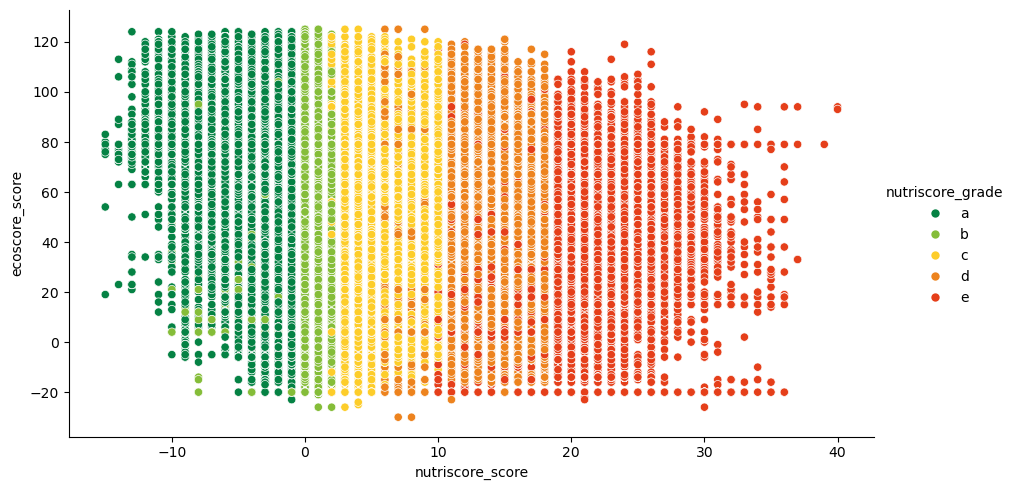

In [65]:
sns.relplot(
    data=df,
    x="nutriscore_score",
    y="ecoscore_score",
    kind="scatter",
    hue="nutriscore_grade",
    palette=colors_nutriscore,
    height=5,
    aspect=1.8,
)

Very colorful indeed, but no luck here.

However, scatter plots and [line plots](https://seaborn.pydata.org/tutorial/relational.html#emphasizing-continuity-with-line-plots) are very useful tools that you can put to better use to look at eg. pairs of nutritional values, or a nutritional value and Nutri-Score.

## Congratulations !

You reached the end of your basic training in Python, pandas and seaborn.

You can proceed to the next notebook for the "Project" in which you will design and conduct your own analysis !

### For the adventurous

OpenFoodFacts has a sister project : [OpenBeautyFacts](https://fr-en.openbeautyfacts.org/), a database on cosmetic products, broadly speaking : from hand dishwashing products to creams, shampoos, deodorants, toothpaste...

OpenBeautyFacts is smaller in size and less mature, but you can try and play with their [data exports](https://fr-en.openbeautyfacts.org/data).

But you can also just contribute to OpenFoodFacts or OpenBeautyFacts, via their website, dedicated apps, or third-party apps !